In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erfc
from scipy.signal import butter, lfilter
from scipy.signal import find_peaks

In [2]:
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
def gauss(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))

def line(x,a,b):
    return a*x+b

def line_vbd(x,a,vbd):
    return a*(x-vbd)

def expo_pulse(x,a1,tau1,a2,tau2):
    return a1*np.exp(-(x-750)/tau1)+a2*np.exp(-(x-750)/tau2)

In [4]:
def AR_filter(wf, tau):
    if wf.shape[0]>1:#multiple waveforms
        wf = wf.transpose()
    wf_filt = np.zeros(wf.shape)
    for i,raw in enumerate(list(reversed(wf))):
        if i>0:
            wf_filt[i] = raw + wf_filt[i-1]*np.exp(-1/tau)
        else:
            wf_filt[i] = raw
    return np.array(list(reversed(wf_filt))).transpose()

# Top tile calibration (0928 data)

The 0928 datasets use laser pulses as the external trigger.

## Directories

In [5]:
voltages = ['20220928_top_61V_laser_ext',
            '20220928_top_63V_laser_ext',
            '20220928_top_65V_laser_ext',
            '20220928_top_67V_laser_ext',
            '20220928_top_69V_laser_ext']

## Charge finger plots and average waveforms

ch0 20220928_top_61V_laser_ext
  TRIGGER POSITION = SAMPLE 816
  TAU1 = 136.45862672610974
  TAU2 = 20.792191557450856
ch0 20220928_top_63V_laser_ext
  TRIGGER POSITION = SAMPLE 816
  TAU1 = 136.27261161997626
  TAU2 = 21.665042149230775
ch0 20220928_top_65V_laser_ext
  TRIGGER POSITION = SAMPLE 816
  TAU1 = 133.14261118836762
  TAU2 = 21.852197535124816
ch0 20220928_top_67V_laser_ext
  TRIGGER POSITION = SAMPLE 816
  TAU1 = 124.72508871309525
  TAU2 = 20.456266397580936
ch0 20220928_top_69V_laser_ext
  TRIGGER POSITION = SAMPLE 816
  TAU1 = 124.7353944910067
  TAU2 = 20.55950397308717
ch1 20220928_top_61V_laser_ext
  TRIGGER POSITION = SAMPLE 816
  TAU1 = 250.18263874886804
  TAU2 = 27.884671684021015
ch1 20220928_top_63V_laser_ext
  TRIGGER POSITION = SAMPLE 816
  TAU1 = 251.44107281519993
  TAU2 = 27.85359442577088
ch1 20220928_top_65V_laser_ext
  TRIGGER POSITION = SAMPLE 816
  TAU1 = 247.74273344194108
  TAU2 = 28.3271813669339
ch1 20220928_top_67V_laser_ext
  TRIGGER POSITION = S

Text(0.5, 0.98, 'Average waveform (x:sample y:ADC count)')

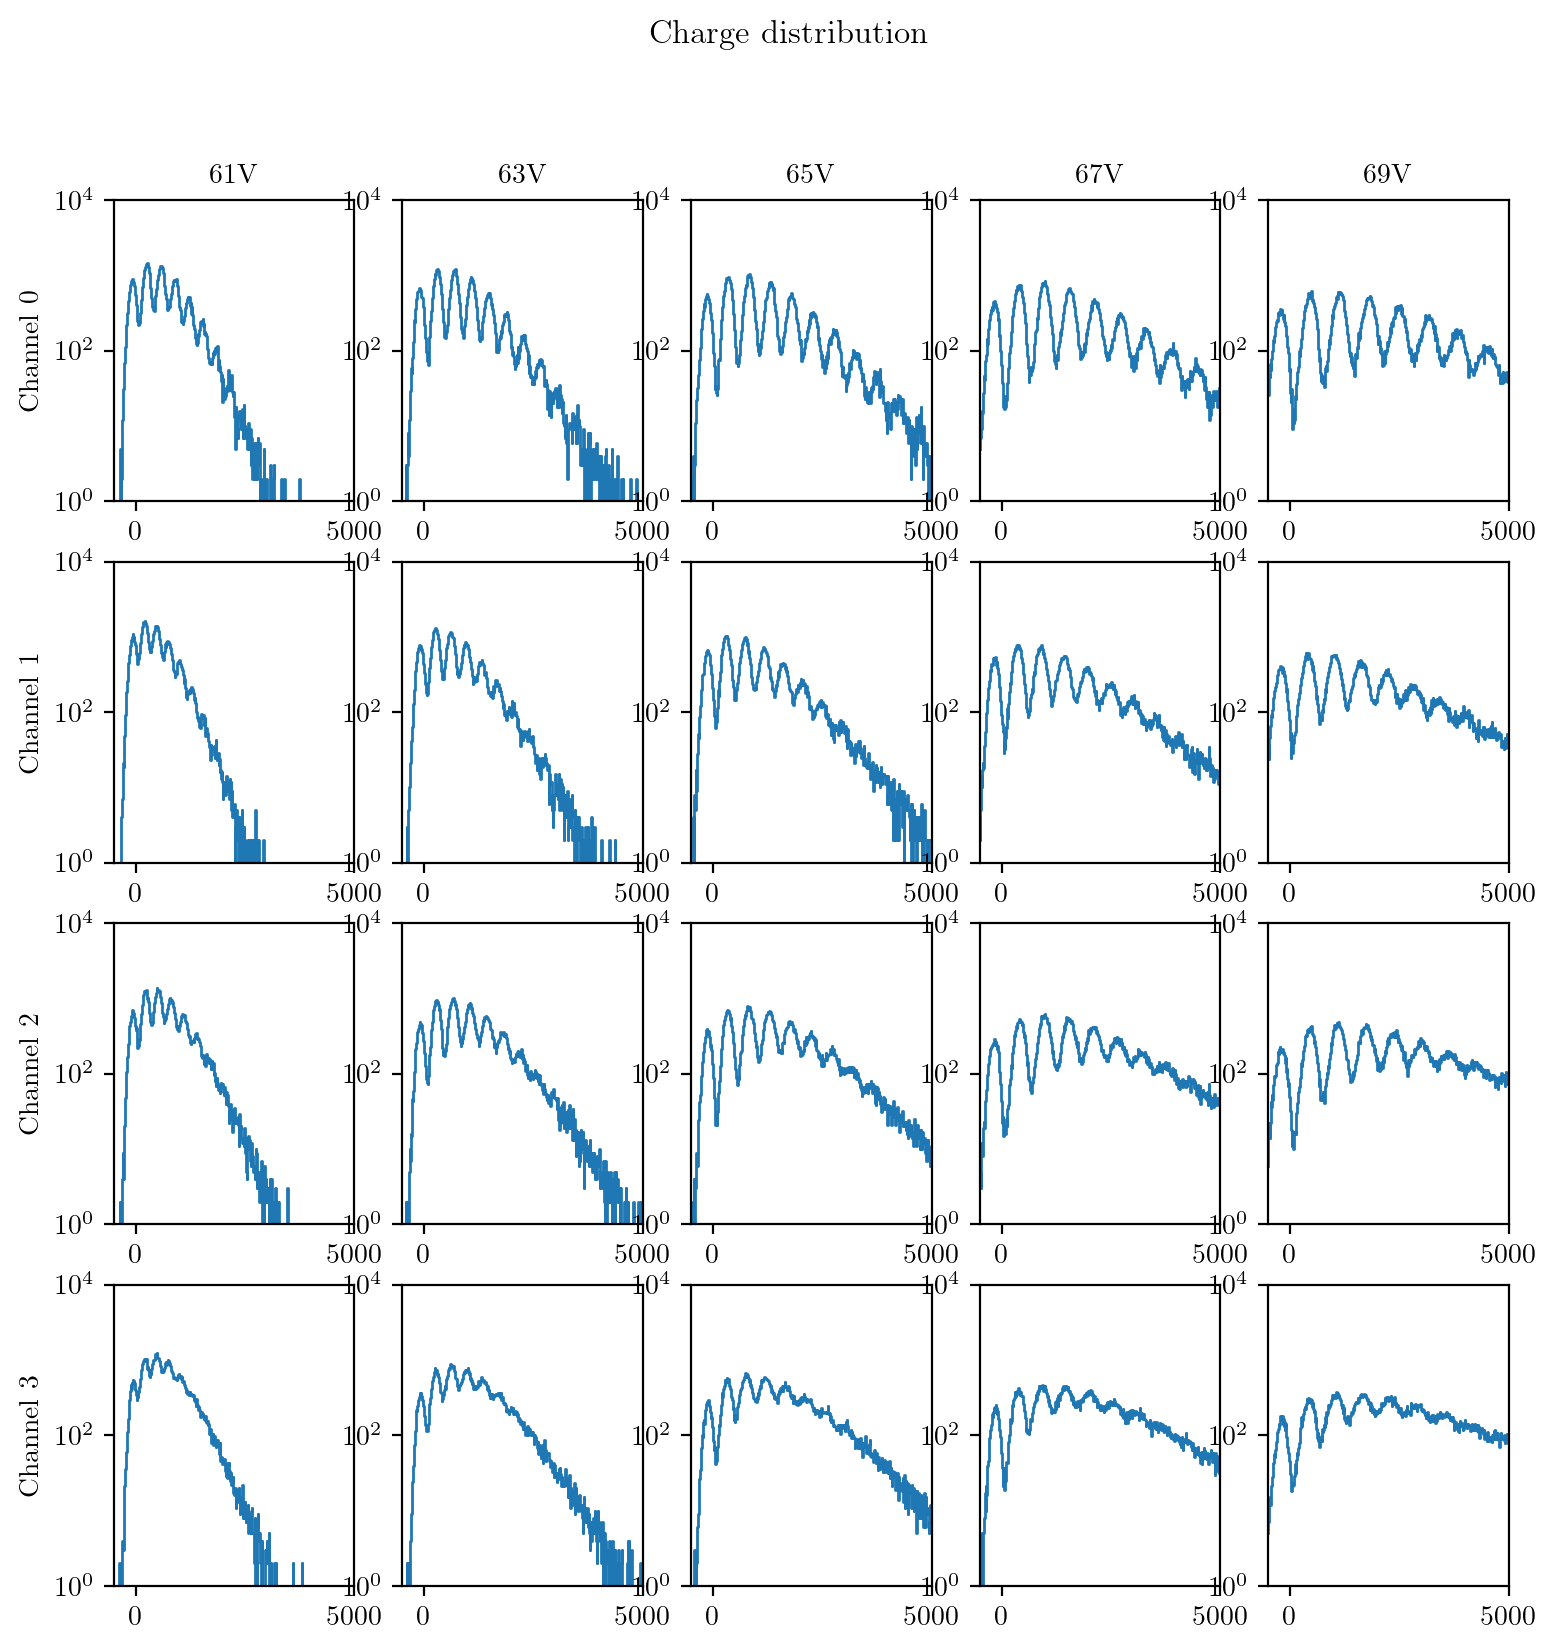

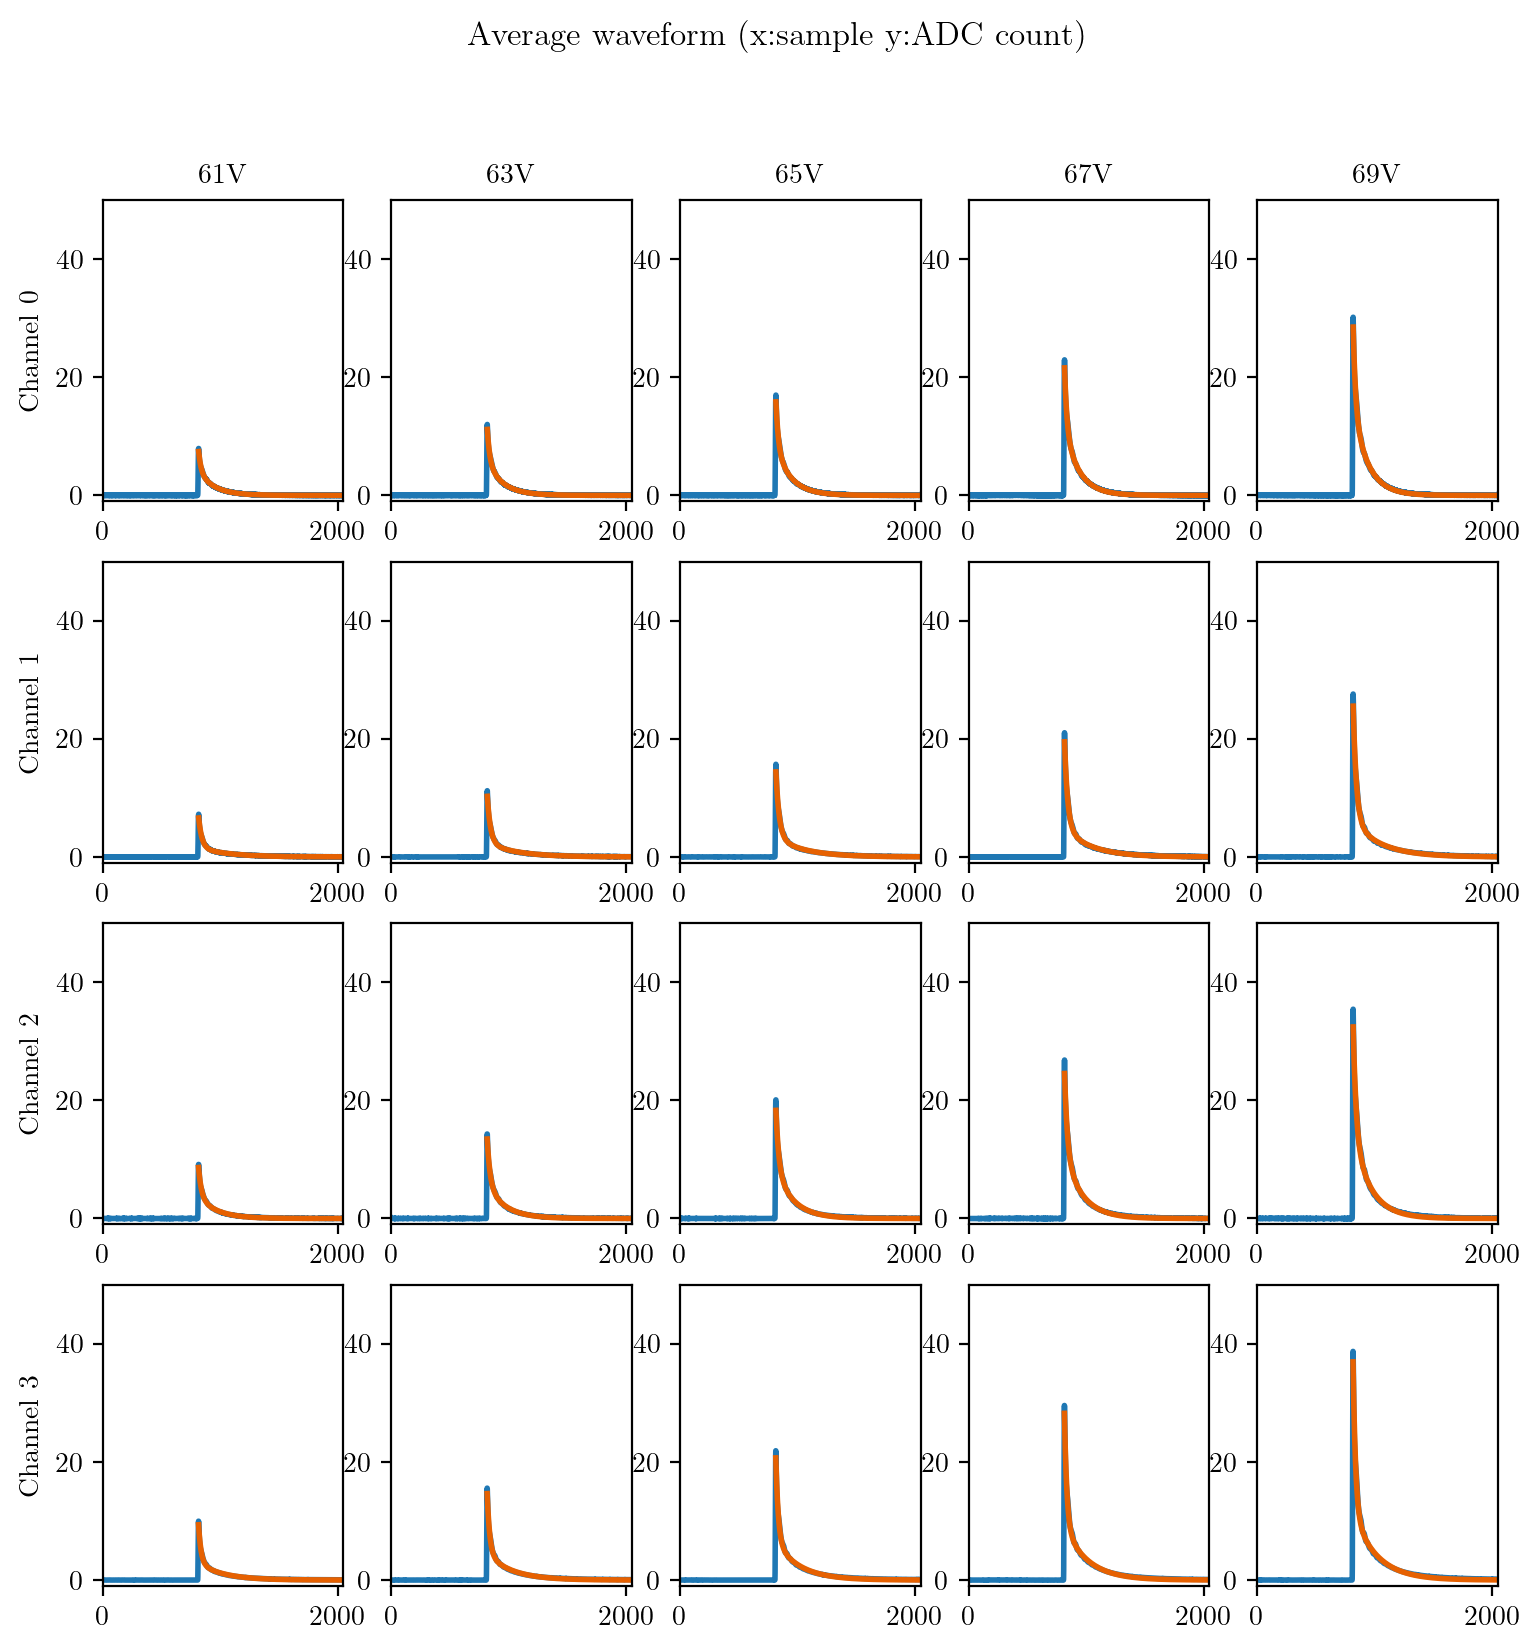

In [6]:
plt.figure(0,figsize=(9,9))#for charge histograms
plt.figure(1,figsize=(9,9))#for avg waveform histograms
bias = [61, 63, 65, 67, 69]
for ch in [0,1,2,3]:
    for volt_id,volt in enumerate(voltages): 
        print("ch{} {}".format(ch, volt))
        fname = "/home/aj9512/jadwin-365/data/sipm/{}/wave{}.dat".format(volt,ch)
        dt = np.dtype('<H')
        file = open(fname, 'rb')
        traces = np.fromfile(file, dtype=dt, count=-1)
        file.close()

        traces = traces.reshape((-1,2048)).astype(float)
        traces = np.tile(np.mean(traces[:,:800],axis=1).reshape(100000,1),(1,2048)) - traces
        integrals = np.sum(traces[:,800:1200],axis=1)
        
        #charge histogram
        h_intg, h_intg_bins = np.histogram(integrals, bins=np.linspace(-500, 5000, 500))#linspace(min, max, nbins)
        plt.figure(0)
        plt.subplot(4,5,ch*5+volt_id+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[volt_id]))
        if volt_id==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.step(h_intg_bins[:-1], h_intg, linewidth=1)
        plt.yscale('log')
        plt.xlim(-500, 5000)
        plt.ylim(1,1e4)

        # average waveform
        meanwf = np.zeros(2048)
        count = 0
        for wf_sub_bsl in traces:
            meanwf = meanwf*count + wf_sub_bsl
            count += 1
            meanwf = meanwf/count
        trig_pos = np.argmax(meanwf)
        print('  TRIGGER POSITION = SAMPLE {}'.format(trig_pos))
        plt.figure(1)
        plt.subplot(4,5,ch*5+volt_id+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[volt_id]))
        if volt_id==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.plot(meanwf)
        popt,pcov = curve_fit(expo_pulse, np.linspace(trig_pos,2047,2048-trig_pos), meanwf[trig_pos:], p0=[10,100,10,10],maxfev=10000)
        plt.plot(np.linspace(trig_pos,2047,2048-trig_pos), expo_pulse(np.linspace(trig_pos,2047,2048-trig_pos),*popt))
        print('  TAU1 = {}'.format(popt[1]))
        print('  TAU2 = {}'.format(popt[3]))
        plt.xlim(0,2048)
        plt.ylim(-1, 50)
plt.figure(0)
plt.suptitle('Charge distribution')
plt.figure(1)
plt.suptitle('Average waveform (x:sample y:ADC count)')

## Auto-regressive filter

In [7]:
h_ampfilt_ch_volt = np.zeros((4,5,1000))
h_ampfilt_bincent_ch_volt = np.zeros((4,5,1000))
h_ampfilt_binwid_ch_volt = np.zeros((4,5))
tau = 25 #AR filter parameter (should = time constant of pulse shape)
for ch in range(4):
    gain_fit = []
    for volt_id,volt in enumerate(voltages): 
        print("ch{} {}".format(ch, volt))
        fname = "/home/aj9512/jadwin-365/data/sipm/{}/wave{}.dat".format(volt,ch)
        dt = np.dtype('<H')
        file = open(fname, 'rb')
        traces = np.fromfile(file, dtype=dt, count=-1)
        file.close()

        traces = traces.reshape((-1,2048)).astype(float)
        #traces = traces[:10000] #use first 10000 waveforms
        traces = np.tile(np.mean(traces[:,:800],axis=1).reshape(100000,1),(1,2048)) - traces

        wfs_filt = AR_filter(traces, tau)
        amps_filt = np.max(wfs_filt,axis=1)
        
        #filtered amplitude histogram
        h_ampfilt, h_ampfilt_bins = np.histogram(amps_filt, bins=np.linspace(0, 1000, 1001))#linspace(min, max, nbins)
        h_ampfilt_bincent_ch_volt[ch][volt_id] = (h_ampfilt_bins[1:]+h_ampfilt_bins[:-1])/2
        h_ampfilt_ch_volt[ch][volt_id] = h_ampfilt
        h_ampfilt_binwid_ch_volt[ch][volt_id] = h_ampfilt_bins[1]-h_ampfilt_bins[0]

ch0 20220928_top_61V_laser_ext
ch0 20220928_top_63V_laser_ext
ch0 20220928_top_65V_laser_ext
ch0 20220928_top_67V_laser_ext
ch0 20220928_top_69V_laser_ext
ch1 20220928_top_61V_laser_ext
ch1 20220928_top_63V_laser_ext
ch1 20220928_top_65V_laser_ext
ch1 20220928_top_67V_laser_ext
ch1 20220928_top_69V_laser_ext
ch2 20220928_top_61V_laser_ext
ch2 20220928_top_63V_laser_ext
ch2 20220928_top_65V_laser_ext
ch2 20220928_top_67V_laser_ext
ch2 20220928_top_69V_laser_ext
ch3 20220928_top_61V_laser_ext
ch3 20220928_top_63V_laser_ext
ch3 20220928_top_65V_laser_ext
ch3 20220928_top_67V_laser_ext
ch3 20220928_top_69V_laser_ext


## Filtered amplitude finger plot and breakdown voltage

Channel 0 Vbd=55.310+/-0.062V
Channel 1 Vbd=55.248+/-0.108V
Channel 2 Vbd=55.003+/-0.098V
Channel 3 Vbd=55.135+/-0.081V


Text(0.5, 0.98, 'Breakdown Voltage')

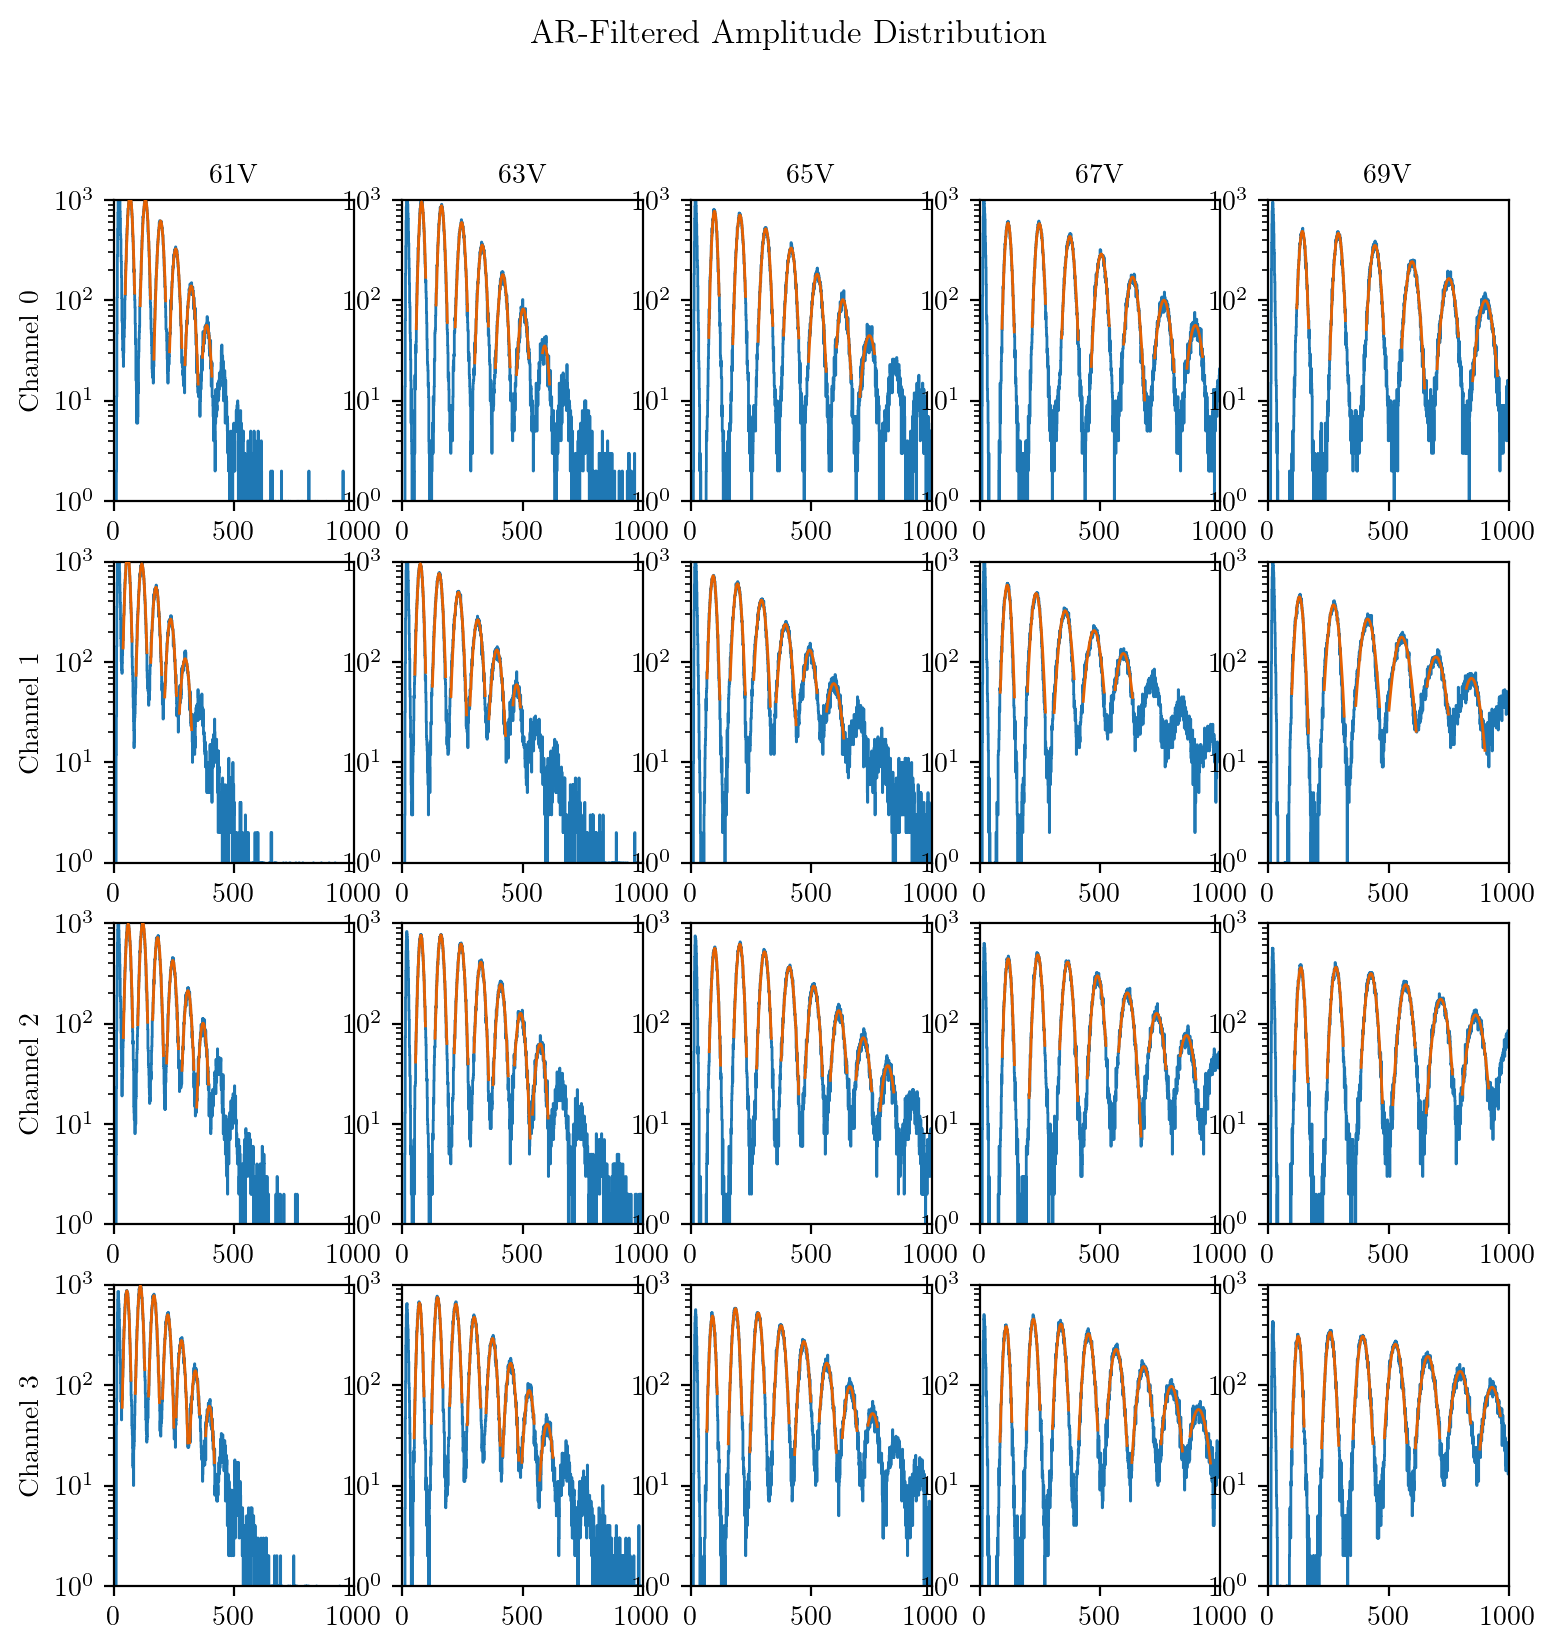

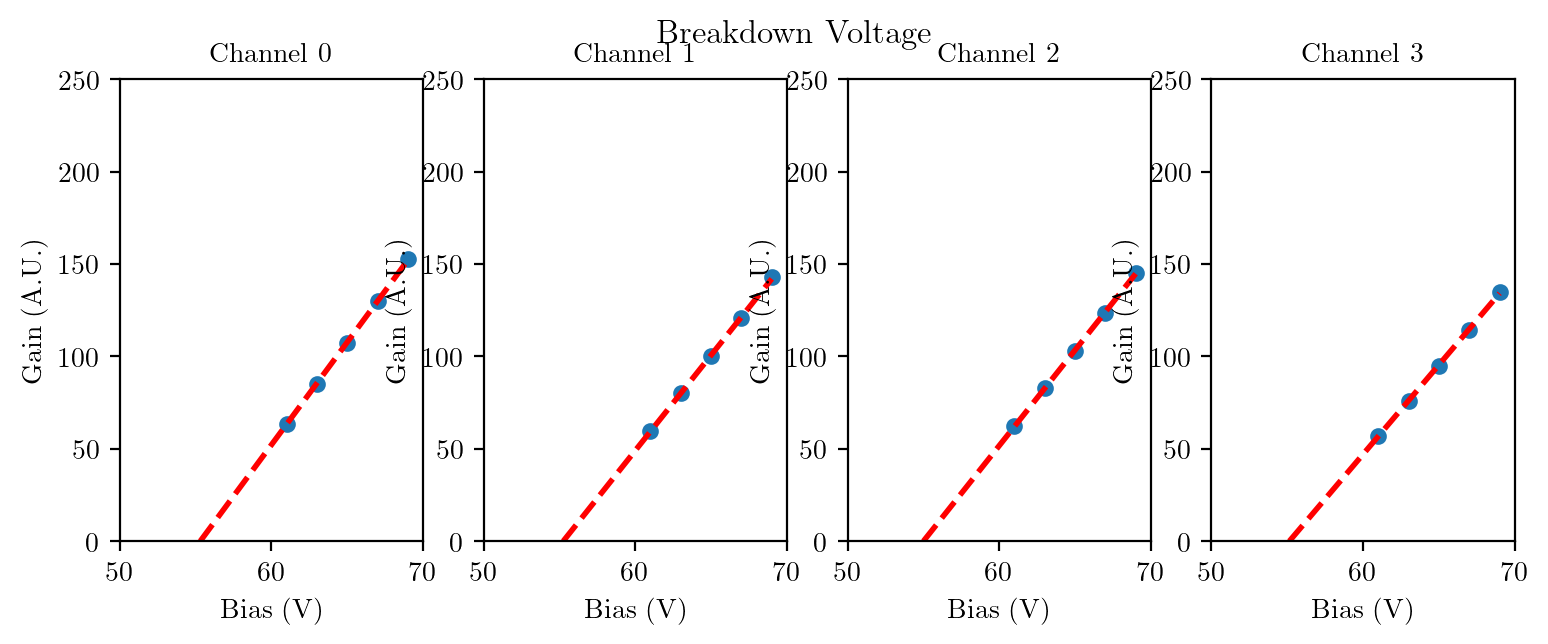

In [9]:
plt.figure(0,figsize=(9,9))#for charge histograms
plt.figure(1,figsize=(9,3))#for breakdown voltage fit
bias = [61, 63, 65, 67, 69]
for ch in range(4):
    gain_fit = []
    for volt_id,volt in enumerate(voltages): 
        #filtered amplitude histogram
        plt.figure(0)
        plt.subplot(4,5,ch*5+volt_id+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[volt_id]))
        if volt_id==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.step(h_ampfilt_bincent_ch_volt[ch][volt_id], h_ampfilt_ch_volt[ch][volt_id], linewidth=1)
        plt.yscale('log')
        plt.xlim(0, 1000)
        plt.ylim(1, 1e3)
        # find pe peaks in histogram
        peaks,pdict = find_peaks(h_ampfilt_ch_volt[ch][volt_id][30:], prominence=30, width=15, distance=20)
#         print("peaks:", peaks)
#         print("pdict:", pdict)
        #fit pe peaks with Gaussian
        pe_mean = []
        for ip,peak_bin in enumerate(peaks):
            peak_bin = peak_bin + 30
            pe_width_bin = int(pdict['widths'][ip])
            pe_width_x = h_ampfilt_binwid_ch_volt[ch][volt_id]*pe_width_bin
            min_bin = peak_bin-pe_width_bin
            max_bin = peak_bin+pe_width_bin
            min_x = h_ampfilt_bincent_ch_volt[ch][volt_id][0] + h_ampfilt_binwid_ch_volt[ch][volt_id]*min_bin
            max_x = h_ampfilt_bincent_ch_volt[ch][volt_id][0] + h_ampfilt_binwid_ch_volt[ch][volt_id]*max_bin
            peak_x = h_ampfilt_bincent_ch_volt[ch][volt_id][0] + h_ampfilt_binwid_ch_volt[ch][volt_id]*peak_bin
            popt,pcov = curve_fit(gauss, h_ampfilt_bincent_ch_volt[ch][volt_id][min_bin:max_bin], h_ampfilt_ch_volt[ch][volt_id][min_bin:max_bin], p0=[h_ampfilt_ch_volt[ch][volt_id][peak_bin], peak_x, pe_width_x], maxfev=10000)
            plt.plot(h_ampfilt_bincent_ch_volt[ch][volt_id][min_bin:max_bin], gauss(h_ampfilt_bincent_ch_volt[ch][volt_id][min_bin:max_bin], *popt), color=colors[1], lw=1, zorder=10)
#             print("[N,mu,sigma]={}".format(popt))
            pe_mean.append(popt[1])
        
        #fit pe-mean vs pe with linear
        xlin = np.linspace(1,len(peaks),len(peaks))
        ylin = pe_mean
        popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], maxfev=10000)
#         print("gain={}(au)".format(popt[0]))
        gain_fit.append(popt[0])
    #breakdown voltage fit and plot
    xlin = bias
    ylin = gain_fit
    popt,pcov = curve_fit(line_vbd, xlin, ylin, p0=[20, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V".format(ch,popt[1],np.sqrt(pcov[1,1])))
    plt.figure(1)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel('Gain (A.U.)')
    plt.xlabel('Bias (V)')
    plt.plot(xlin,ylin,'o', markersize=5)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,70)
    plt.ylim(0,250)
        
plt.figure(0)
plt.suptitle('AR-Filtered Amplitude Distribution')
plt.figure(1)
plt.suptitle('Breakdown Voltage')

# Bottome tile calibration (0928 data)

This dataset uses laser pulses as the external trigger.

## Directories

In [12]:
voltages = ['20220928_bottom_61V_laser_ext',
            '20220928_bottom_63V_laser_ext',
            '20220928_bottom_65V_laser_ext',
            '20220928_bottom_67V_laser_ext',
            '20220928_bottom_69V_laser_ext']

## Charge finger plots and average waveforms

ch0 20220928_bottom_61V_laser_ext
  TRIGGER POSITION = SAMPLE 815
  TAU1 = 322.4594115249805
  TAU2 = 22.362504946628654
ch0 20220928_bottom_63V_laser_ext
  TRIGGER POSITION = SAMPLE 815
  TAU1 = 307.87175380625814
  TAU2 = 21.883327514775445
ch0 20220928_bottom_65V_laser_ext
  TRIGGER POSITION = SAMPLE 815
  TAU1 = 303.886076938971
  TAU2 = 22.08110952540532
ch0 20220928_bottom_67V_laser_ext
  TRIGGER POSITION = SAMPLE 815
  TAU1 = 291.1614936171232
  TAU2 = 21.974174790912812
ch0 20220928_bottom_69V_laser_ext
  TRIGGER POSITION = SAMPLE 815
  TAU1 = 290.97866919916777
  TAU2 = 21.82634973470855
ch1 20220928_bottom_61V_laser_ext
  TRIGGER POSITION = SAMPLE 815
  TAU1 = 374.2789181855578
  TAU2 = 28.30347030854357
ch1 20220928_bottom_63V_laser_ext
  TRIGGER POSITION = SAMPLE 815
  TAU1 = 370.0298694434006
  TAU2 = 28.148467228456006
ch1 20220928_bottom_65V_laser_ext
  TRIGGER POSITION = SAMPLE 815
  TAU1 = 358.71021104745193
  TAU2 = 28.62893698243012
ch1 20220928_bottom_67V_laser_ext


Text(0.5, 0.98, 'Average waveform (x:sample y:ADC count)')

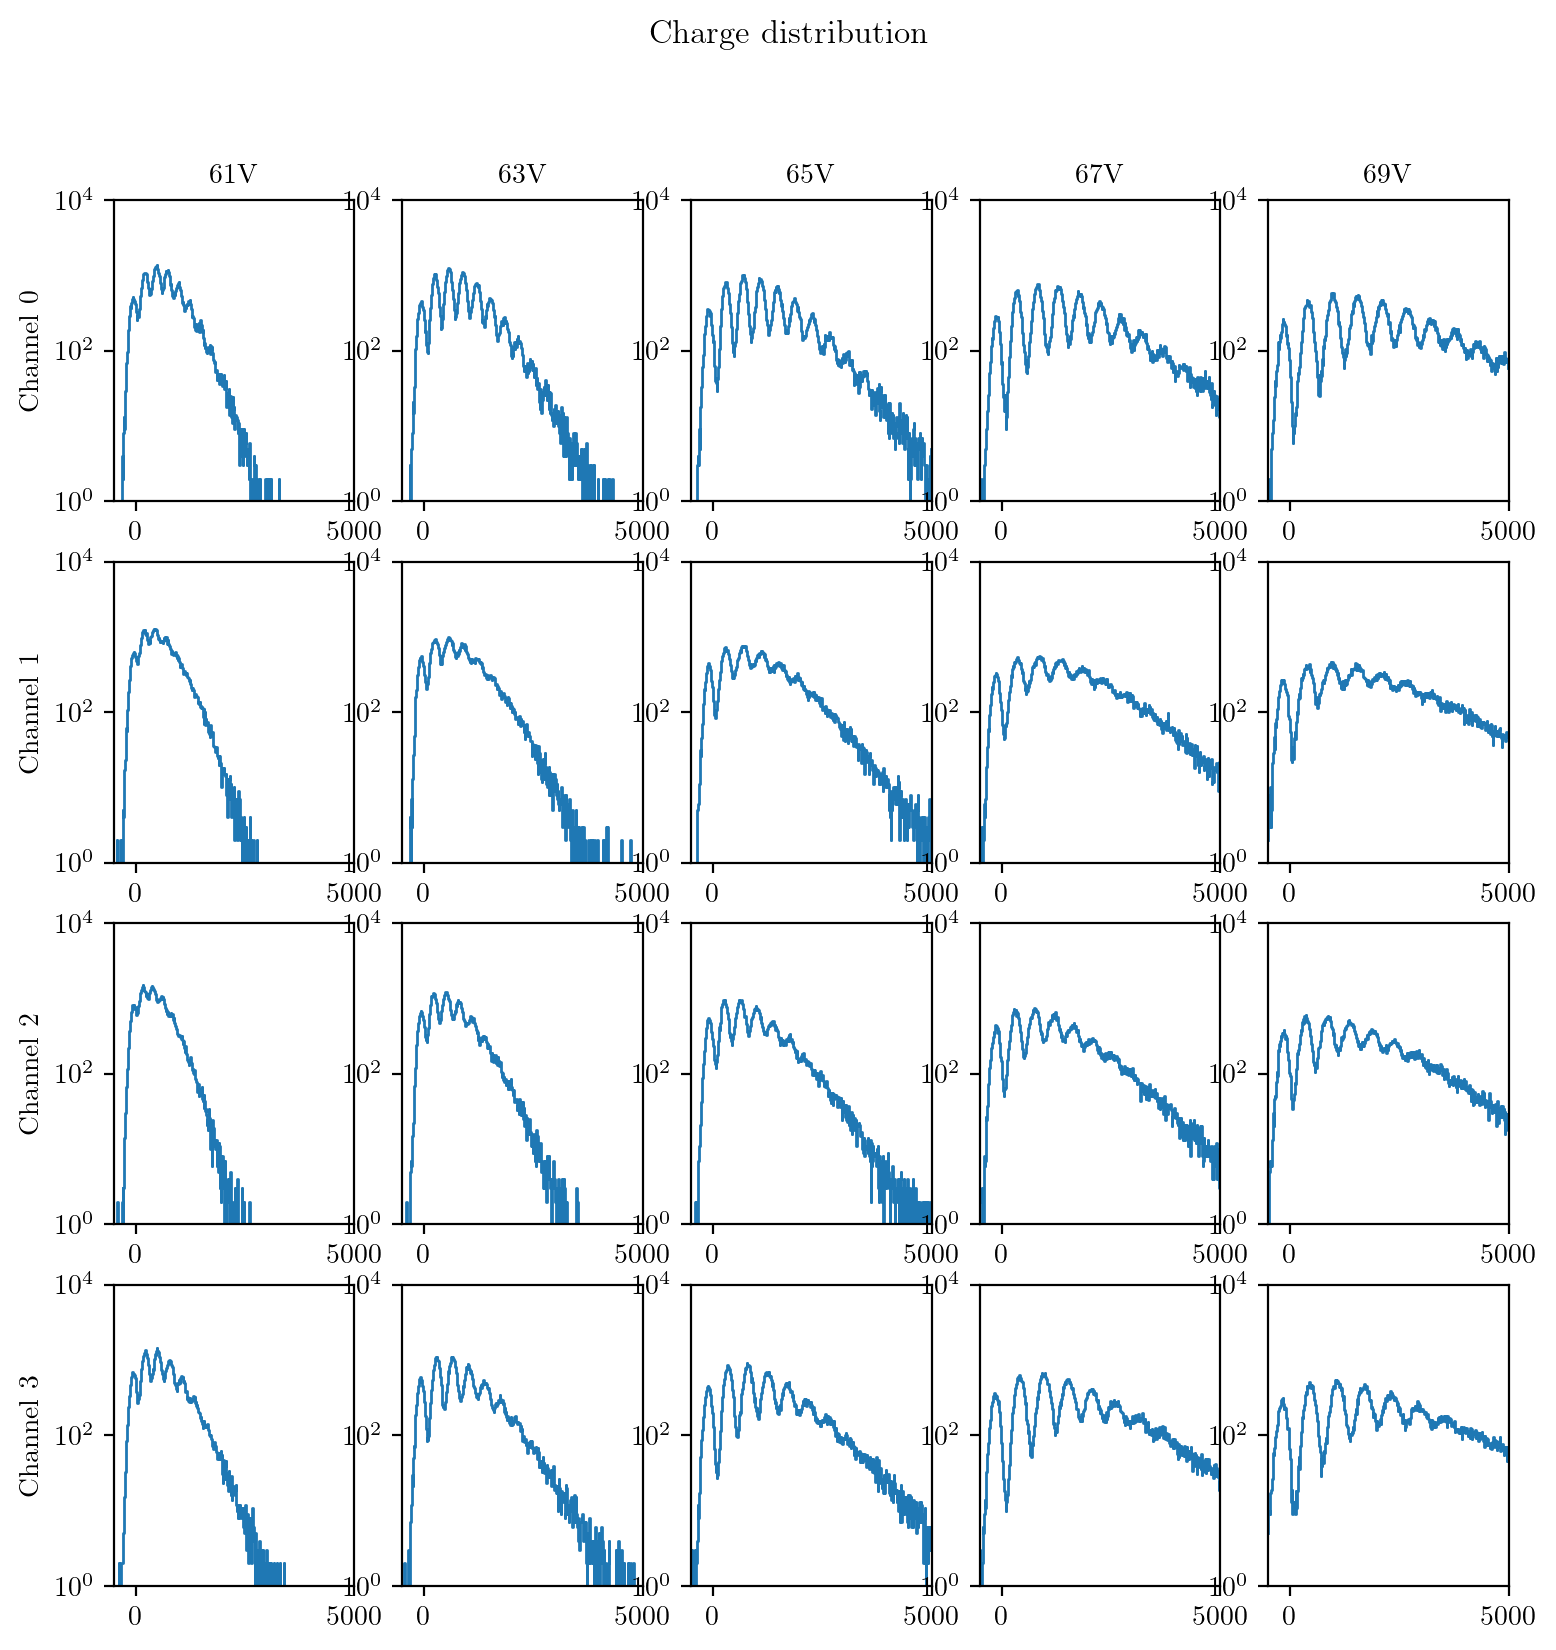

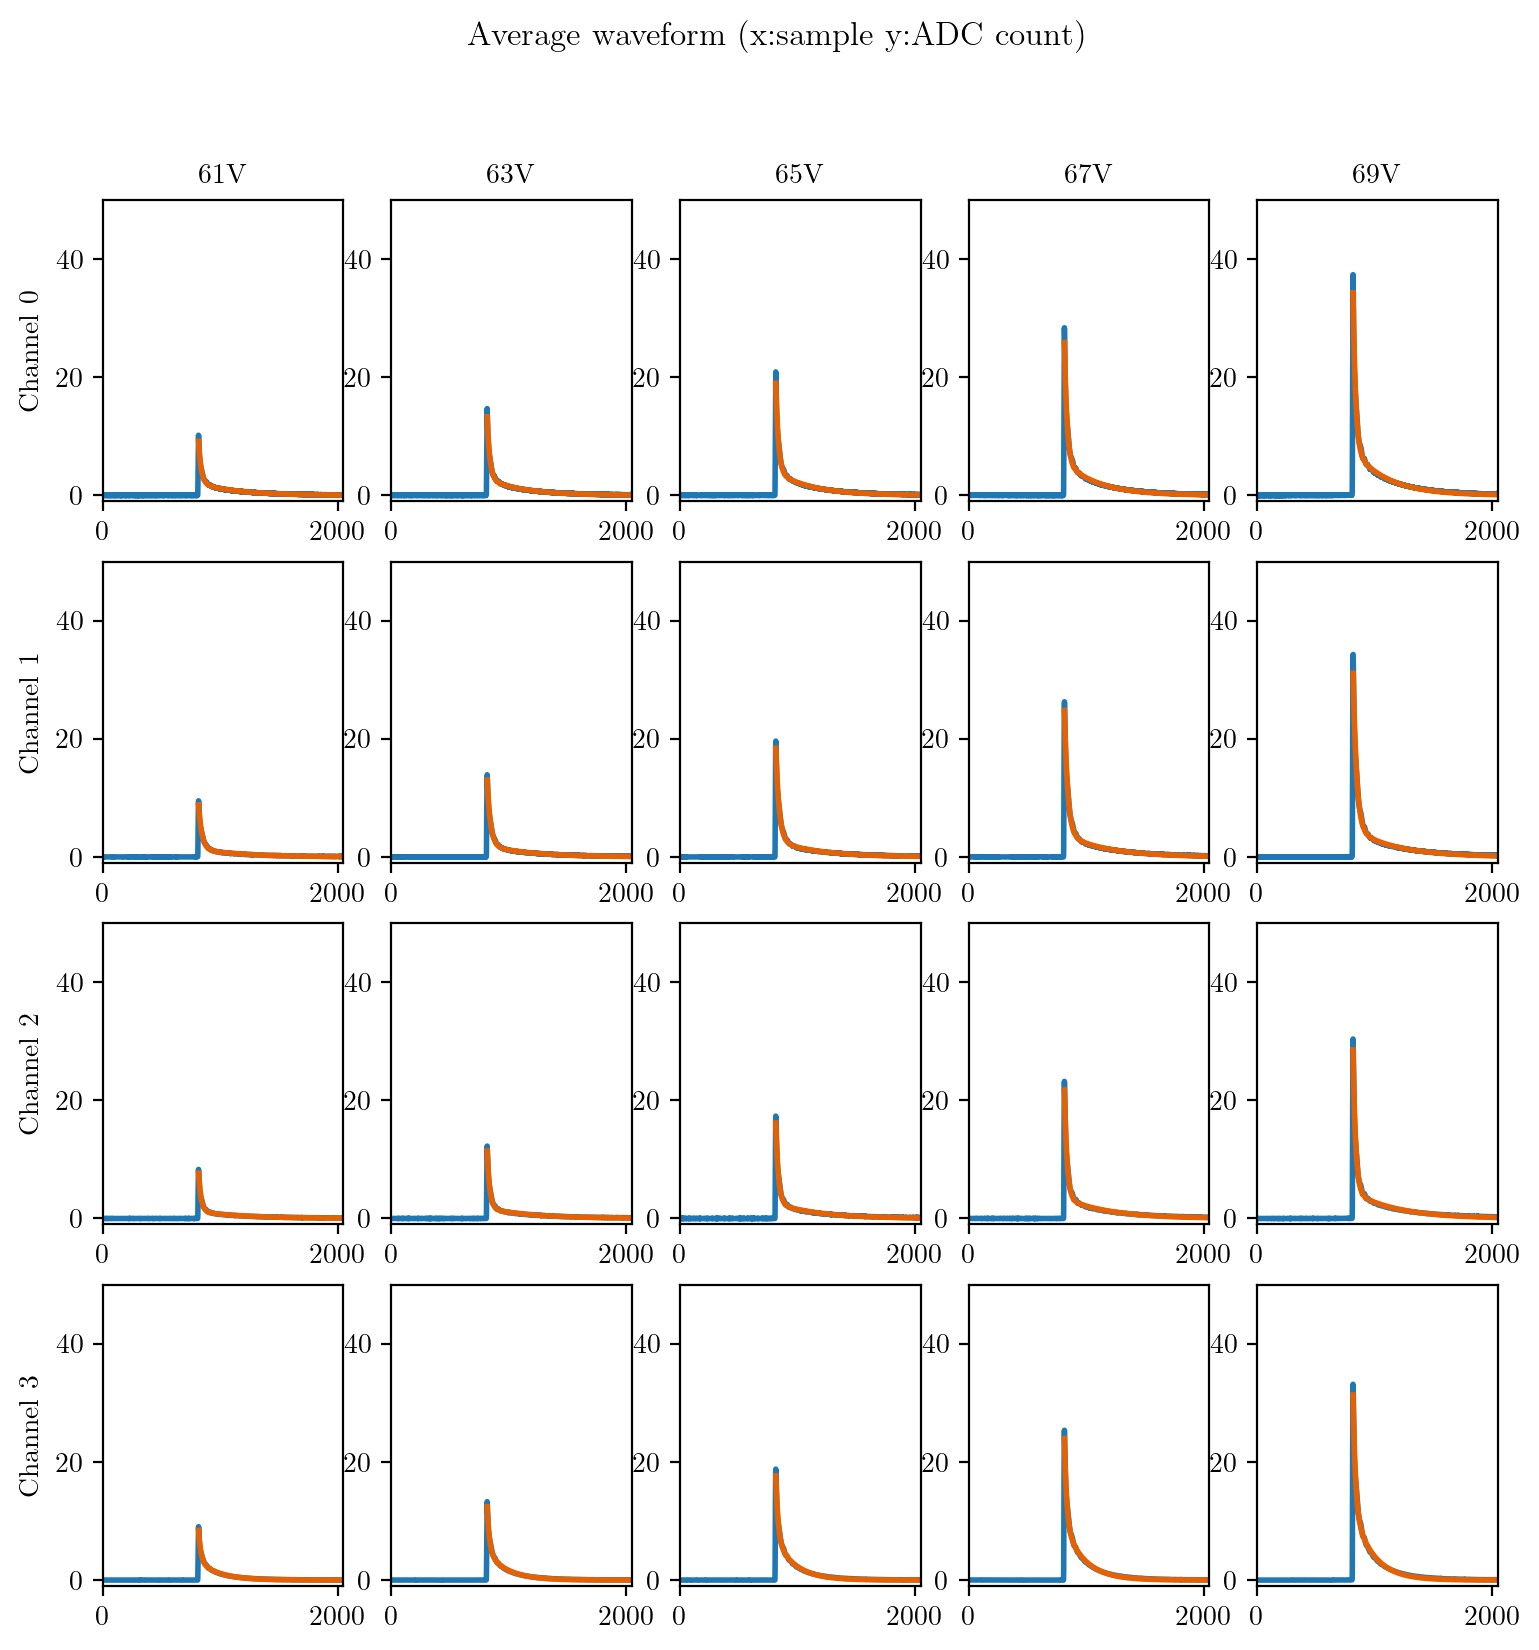

In [13]:
plt.figure(0,figsize=(9,9))#for charge histograms
plt.figure(1,figsize=(9,9))#for avg waveform histograms
bias = [61, 63, 65, 67, 69]
for ch in [0,1,2,3]:
    for volt_id,volt in enumerate(voltages): 
        print("ch{} {}".format(ch, volt))
        fname = "/home/aj9512/jadwin-365/data/sipm/{}/wave{}.dat".format(volt,ch)
        dt = np.dtype('<H')
        file = open(fname, 'rb')
        traces = np.fromfile(file, dtype=dt, count=-1)
        file.close()

        traces = traces.reshape((-1,2048)).astype(float)
        traces = np.tile(np.mean(traces[:,:800],axis=1).reshape(100000,1),(1,2048)) - traces
        integrals = np.sum(traces[:,800:1200],axis=1)
        
        #charge histogram
        h_intg, h_intg_bins = np.histogram(integrals, bins=np.linspace(-500, 5000, 500))#linspace(min, max, nbins)
        plt.figure(0)
        plt.subplot(4,5,ch*5+volt_id+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[volt_id]))
        if volt_id==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.step(h_intg_bins[:-1], h_intg, linewidth=1)
        plt.yscale('log')
        plt.xlim(-500, 5000)
        plt.ylim(1,1e4)

        # average waveform
        meanwf = np.zeros(2048)
        count = 0
        for wf_sub_bsl in traces:
            meanwf = meanwf*count + wf_sub_bsl
            count += 1
            meanwf = meanwf/count
        trig_pos = np.argmax(meanwf)
        print('  TRIGGER POSITION = SAMPLE {}'.format(trig_pos))
        plt.figure(1)
        plt.subplot(4,5,ch*5+volt_id+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[volt_id]))
        if volt_id==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.plot(meanwf)
        popt,pcov = curve_fit(expo_pulse, np.linspace(trig_pos,2047,2048-trig_pos), meanwf[trig_pos:], p0=[10,100,10,10],maxfev=10000)
        plt.plot(np.linspace(trig_pos,2047,2048-trig_pos), expo_pulse(np.linspace(trig_pos,2047,2048-trig_pos),*popt))
        print('  TAU1 = {}'.format(popt[1]))
        print('  TAU2 = {}'.format(popt[3]))
        plt.xlim(0,2048)
        plt.ylim(-1, 50)
plt.figure(0)
plt.suptitle('Charge distribution')
plt.figure(1)
plt.suptitle('Average waveform (x:sample y:ADC count)')

## Auto-regressive filter

In [14]:
h_ampfilt_ch_volt = np.zeros((4,5,1000))
h_ampfilt_bincent_ch_volt = np.zeros((4,5,1000))
h_ampfilt_binwid_ch_volt = np.zeros((4,5))
tau = 20 #AR filter parameter (should = time constant of pulse shape)
for ch in range(4):
    gain_fit = []
    for volt_id,volt in enumerate(voltages): 
        print("ch{} {}".format(ch, volt))
        fname = "/home/aj9512/jadwin-365/data/sipm/{}/wave{}.dat".format(volt,ch)
        dt = np.dtype('<H')
        file = open(fname, 'rb')
        traces = np.fromfile(file, dtype=dt, count=-1)
        file.close()

        traces = traces.reshape((-1,2048)).astype(float)
        #traces = traces[:10000] #use first 10000 waveforms
        traces = np.tile(np.mean(traces[:,:800],axis=1).reshape(100000,1),(1,2048)) - traces

        wfs_filt = AR_filter(traces, tau)
        amps_filt = np.max(wfs_filt,axis=1)
        
        #filtered amplitude histogram
        h_ampfilt, h_ampfilt_bins = np.histogram(amps_filt, bins=np.linspace(0, 1000, 1001))#linspace(min, max, nbins)
        h_ampfilt_bincent_ch_volt[ch][volt_id] = (h_ampfilt_bins[1:]+h_ampfilt_bins[:-1])/2
        h_ampfilt_ch_volt[ch][volt_id] = h_ampfilt
        h_ampfilt_binwid_ch_volt[ch][volt_id] = h_ampfilt_bins[1]-h_ampfilt_bins[0]

ch0 20220928_bottom_61V_laser_ext
ch0 20220928_bottom_63V_laser_ext
ch0 20220928_bottom_65V_laser_ext
ch0 20220928_bottom_67V_laser_ext
ch0 20220928_bottom_69V_laser_ext
ch1 20220928_bottom_61V_laser_ext
ch1 20220928_bottom_63V_laser_ext
ch1 20220928_bottom_65V_laser_ext
ch1 20220928_bottom_67V_laser_ext
ch1 20220928_bottom_69V_laser_ext
ch2 20220928_bottom_61V_laser_ext
ch2 20220928_bottom_63V_laser_ext
ch2 20220928_bottom_65V_laser_ext
ch2 20220928_bottom_67V_laser_ext
ch2 20220928_bottom_69V_laser_ext
ch3 20220928_bottom_61V_laser_ext
ch3 20220928_bottom_63V_laser_ext
ch3 20220928_bottom_65V_laser_ext
ch3 20220928_bottom_67V_laser_ext
ch3 20220928_bottom_69V_laser_ext


## Filtered amplitude finger plot and breakdown voltage

Channel 0 Vbd=55.271+/-0.072V
Channel 1 Vbd=55.451+/-0.151V
Channel 2 Vbd=55.026+/-0.118V
Channel 3 Vbd=55.238+/-0.163V


Text(0.5, 0.98, 'Breakdown Voltage')

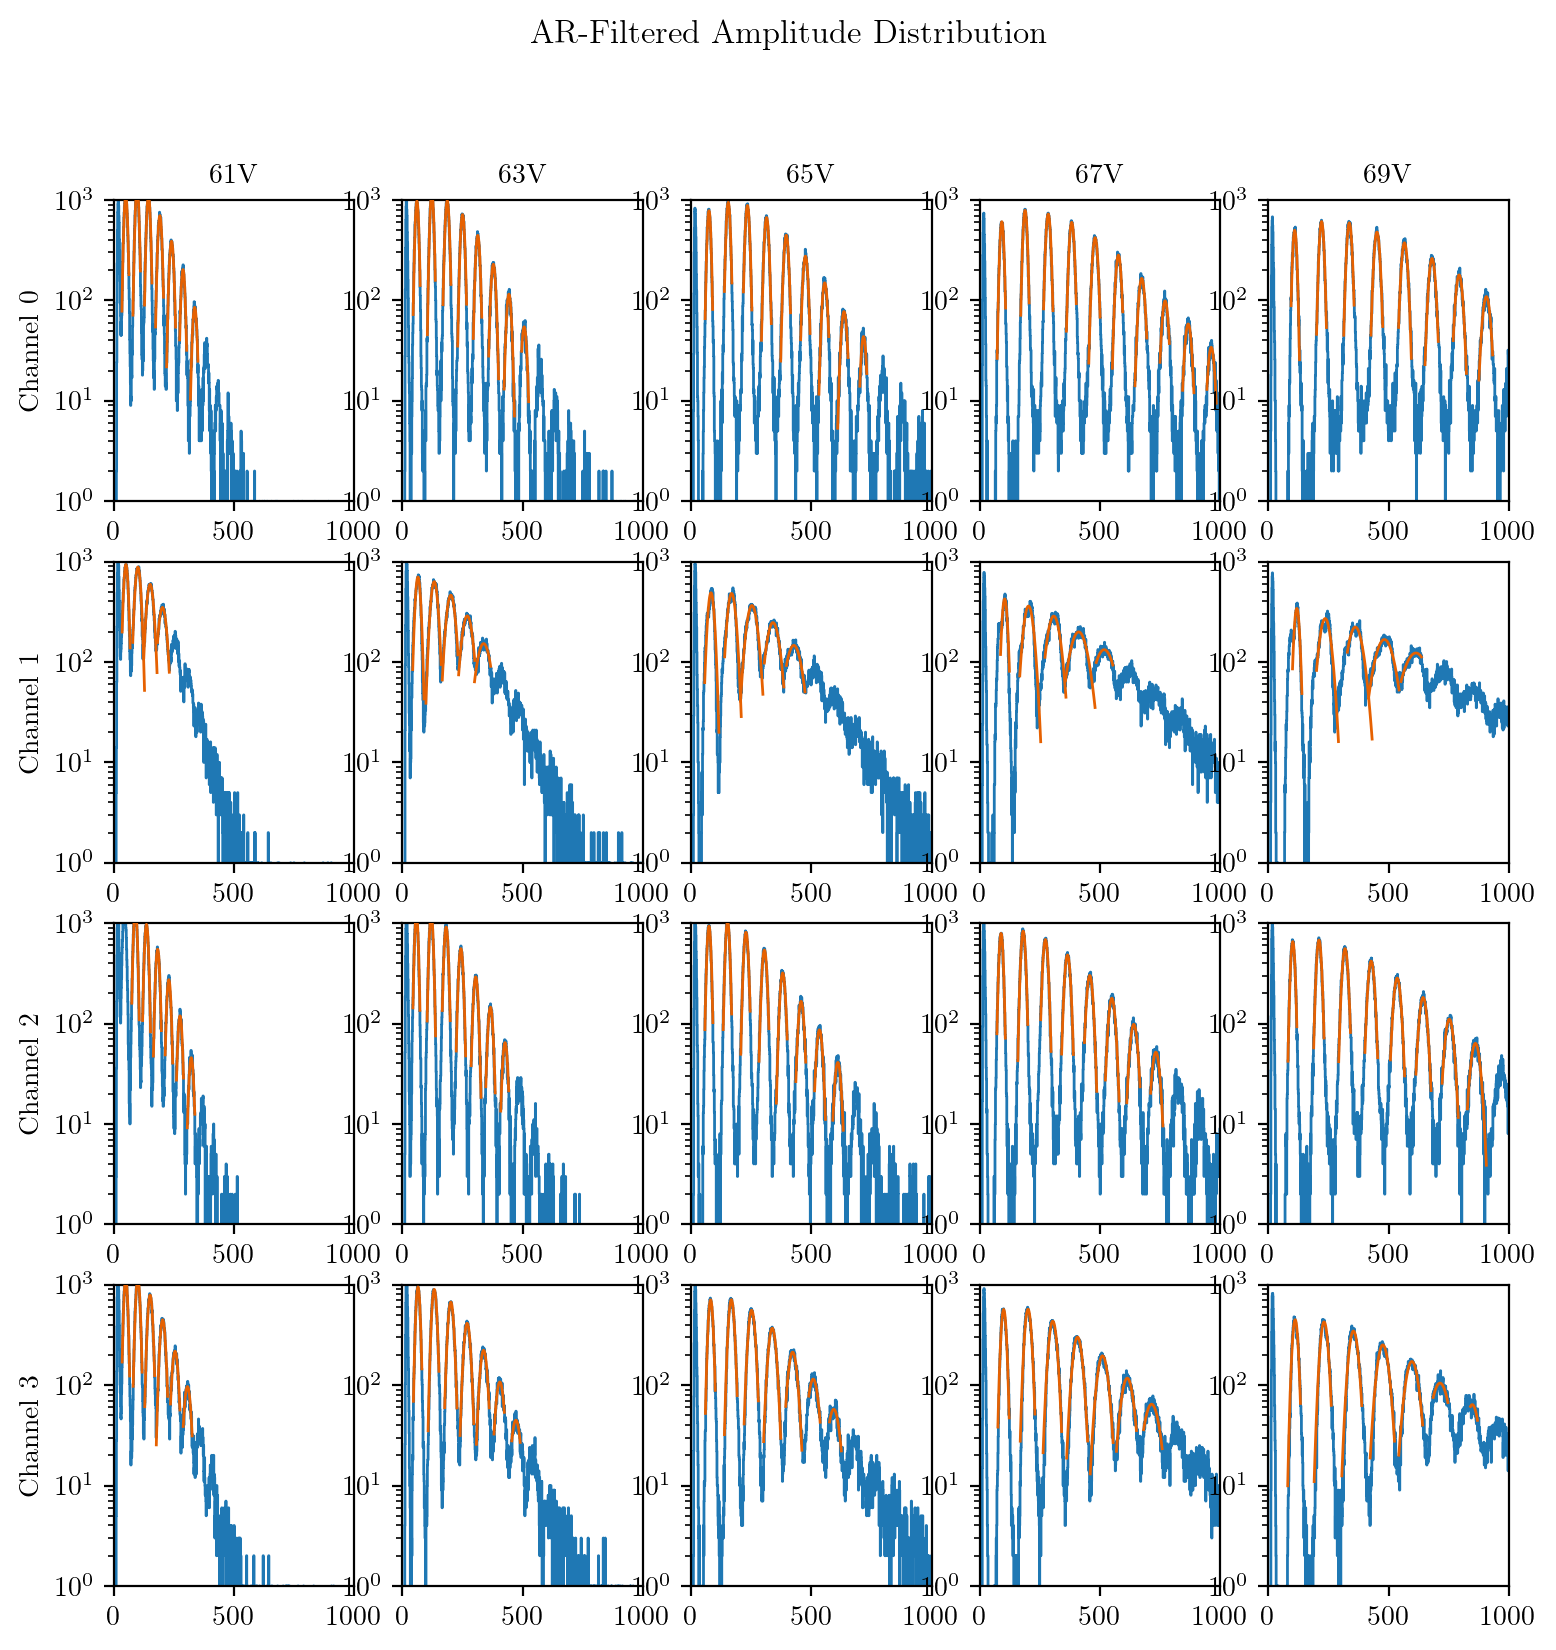

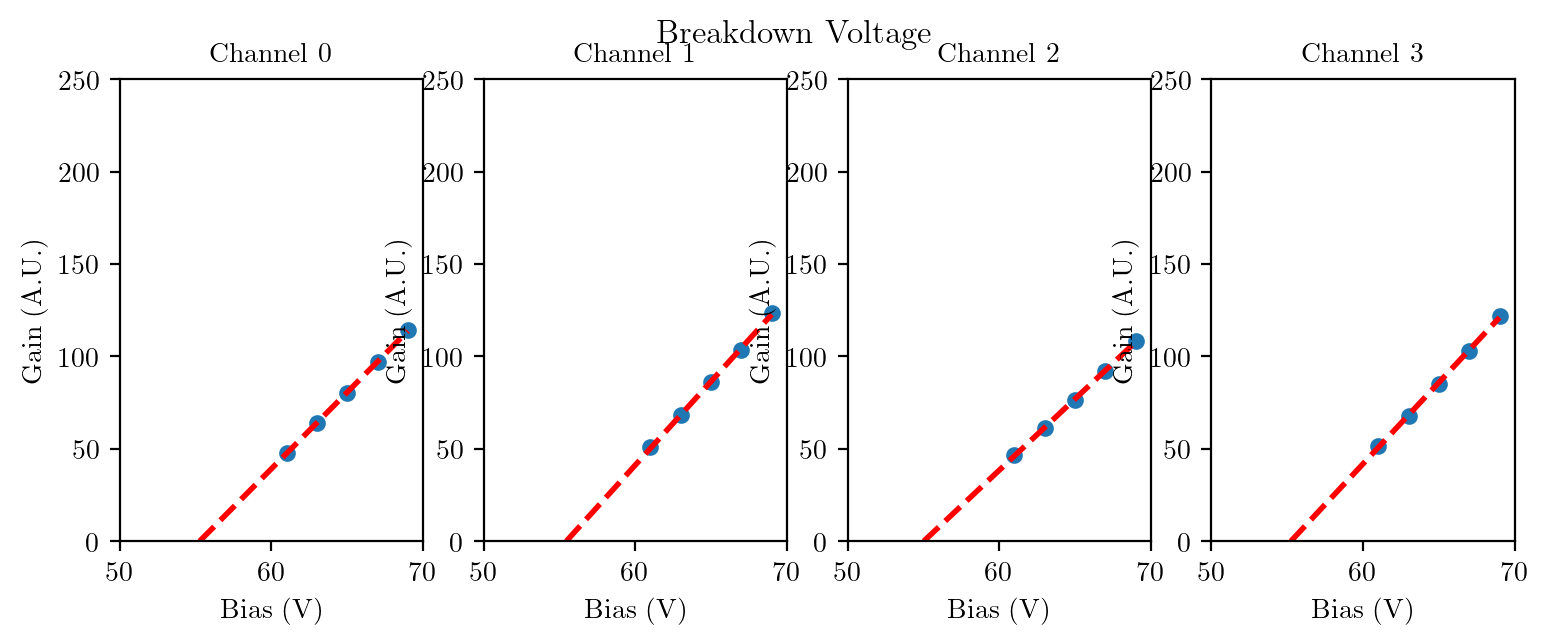

In [16]:
plt.figure(0,figsize=(9,9))#for charge histograms
plt.figure(1,figsize=(9,3))#for breakdown voltage fit
bias = [61, 63, 65, 67, 69]
for ch in range(4):
    gain_fit = []
    for volt_id,volt in enumerate(voltages): 
        #filtered amplitude histogram
        plt.figure(0)
        plt.subplot(4,5,ch*5+volt_id+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[volt_id]))
        if volt_id==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.step(h_ampfilt_bincent_ch_volt[ch][volt_id], h_ampfilt_ch_volt[ch][volt_id], linewidth=1)
        plt.yscale('log')
        plt.xlim(0, 1000)
        plt.ylim(1, 1e3)
        # find pe peaks in histogram
        peaks,pdict = find_peaks(h_ampfilt_ch_volt[ch][volt_id][30:], prominence=35, width=15, distance=20)
#         print("peaks:", peaks)
#         print("pdict:", pdict)
        #fit pe peaks with Gaussian
        pe_mean = []
        for ip,peak_bin in enumerate(peaks):
            peak_bin = peak_bin + 30
            pe_width_bin = int(pdict['widths'][ip])
            pe_width_x = h_ampfilt_binwid_ch_volt[ch][volt_id]*pe_width_bin
            min_bin = peak_bin-pe_width_bin
            max_bin = peak_bin+pe_width_bin
            min_x = h_ampfilt_bincent_ch_volt[ch][volt_id][0] + h_ampfilt_binwid_ch_volt[ch][volt_id]*min_bin
            max_x = h_ampfilt_bincent_ch_volt[ch][volt_id][0] + h_ampfilt_binwid_ch_volt[ch][volt_id]*max_bin
            peak_x = h_ampfilt_bincent_ch_volt[ch][volt_id][0] + h_ampfilt_binwid_ch_volt[ch][volt_id]*peak_bin
            popt,pcov = curve_fit(gauss, h_ampfilt_bincent_ch_volt[ch][volt_id][min_bin:max_bin], h_ampfilt_ch_volt[ch][volt_id][min_bin:max_bin], p0=[h_ampfilt_ch_volt[ch][volt_id][peak_bin], peak_x, pe_width_x], maxfev=10000)
            plt.plot(h_ampfilt_bincent_ch_volt[ch][volt_id][min_bin:max_bin], gauss(h_ampfilt_bincent_ch_volt[ch][volt_id][min_bin:max_bin], *popt), color=colors[1], lw=1, zorder=10)
#             print("[N,mu,sigma]={}".format(popt))
            pe_mean.append(popt[1])
        
        #fit pe-mean vs pe with linear
        xlin = np.linspace(1,len(peaks),len(peaks))
        ylin = pe_mean
        popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], maxfev=10000)
#         print("gain={}(au)".format(popt[0]))
        gain_fit.append(popt[0])
    #breakdown voltage fit and plot
    xlin = bias
    ylin = gain_fit
    popt,pcov = curve_fit(line_vbd, xlin, ylin, p0=[20, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V".format(ch,popt[1],np.sqrt(pcov[1,1])))
    plt.figure(1)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel('Gain (A.U.)')
    plt.xlabel('Bias (V)')
    plt.plot(xlin,ylin,'o', markersize=5)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,70)
    plt.ylim(0,250)
        
plt.figure(0)
plt.suptitle('AR-Filtered Amplitude Distribution')
plt.figure(1)
plt.suptitle('Breakdown Voltage')

# Top tile directories (0923 data)

In [9]:
voltages = ['20220923_60V_laser_3725thres',
            '20220923_61V_laser_3722thres',
            '20220923_62V_laser_3722thres',
            '20220923_63V_laser_3720thres',
            '20220923_64V_laser_3718thres']

## Charge finger plot and average waveform
The charge finger plots have bad resolution for bias below 62V.
Average waveforms show the trigger position at sample 750 ($3\rm\mu s$)

ch0 20220923_60V_laser_3725thres
[  2.63703731 212.3232396    7.79036538  45.20076636]
ch0 20220923_61V_laser_3722thres
[  3.89994286 207.35304062  11.81357083  47.23710143]
ch0 20220923_62V_laser_3722thres
[  3.72223608 209.09923876  10.59237098  50.28803188]
ch0 20220923_63V_laser_3720thres
[  5.88113761 197.4967432   15.30454142  43.27409166]
ch0 20220923_64V_laser_3718thres
[  6.14682949 215.32436876  19.44528753  45.0730793 ]
ch1 20220923_60V_laser_3725thres
[  2.10076578 260.40656356   8.57939321  36.40631775]
ch1 20220923_61V_laser_3722thres
[  3.59448403 247.67959891  14.47469951  33.72951385]
ch1 20220923_62V_laser_3722thres
[  3.31744749 263.5541422   14.35095177  35.57853957]
ch1 20220923_63V_laser_3720thres
[  4.74384702 244.12138418  21.04234476  34.02201124]
ch1 20220923_64V_laser_3718thres
[  5.78707498 251.19517714  26.10210722  34.218954  ]
ch2 20220923_60V_laser_3725thres
[  1.21992136 304.55500812   7.88483357  36.24695877]
ch2 20220923_61V_laser_3722thres


/tmp/ipykernel_2498319/1876235883.py:11: RuntimeWarning: overflow encountered in exp
  return a1*np.exp(-(x-750)/tau1)+a2*np.exp(-(x-750)/tau2)
/tmp/ipykernel_2498319/1876235883.py:11: RuntimeWarning: overflow encountered in multiply
  return a1*np.exp(-(x-750)/tau1)+a2*np.exp(-(x-750)/tau2)


[  5.01223866 140.67390945 -28.77916916   1.97046406]
ch2 20220923_62V_laser_3722thres
[  5.02697467 140.21454648  -2.82535316   0.21321879]
ch2 20220923_63V_laser_3720thres
[  2.72083456 281.04931629  18.2264696   35.42339639]
ch2 20220923_64V_laser_3718thres
[  3.23741106 293.7248516   21.77382639  36.34734463]
ch3 20220923_60V_laser_3725thres
[  2.76604267 163.98838171   6.14031989  32.344673  ]
ch3 20220923_61V_laser_3722thres
[  7.00425606 117.05352562  -8.78318911   1.71826472]
ch3 20220923_62V_laser_3722thres
[  4.53276407 158.84196464  10.28309411  32.99952686]
ch3 20220923_63V_laser_3720thres
[  6.34524749 156.32211568  14.67526533  32.73361454]
ch3 20220923_64V_laser_3718thres
[  7.33008588 162.1660496   17.51275732  34.96890078]


Text(0.5, 0.98, 'Average waveform (x:sample y:ADC count)')

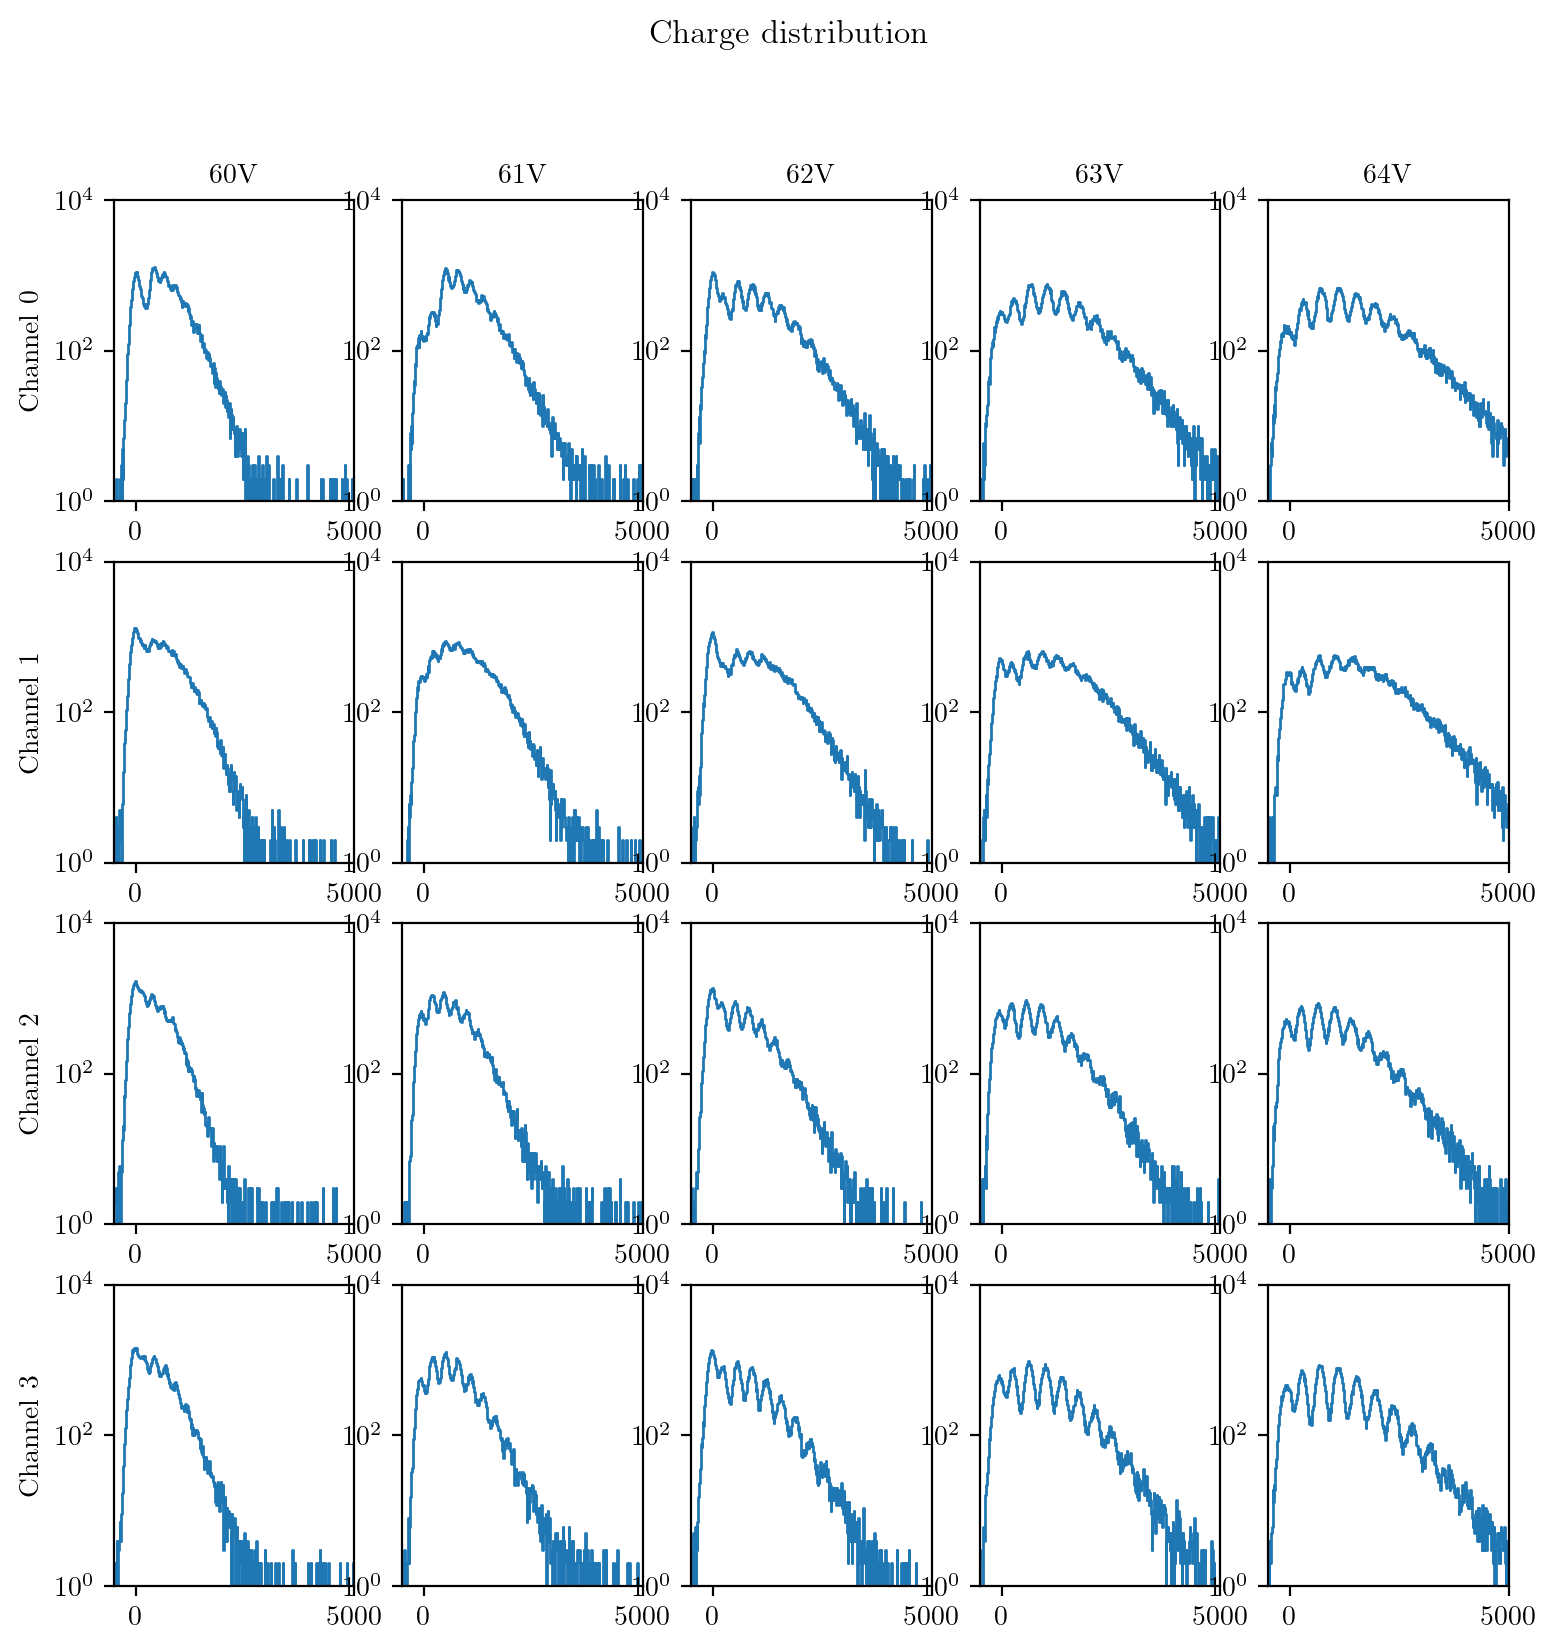

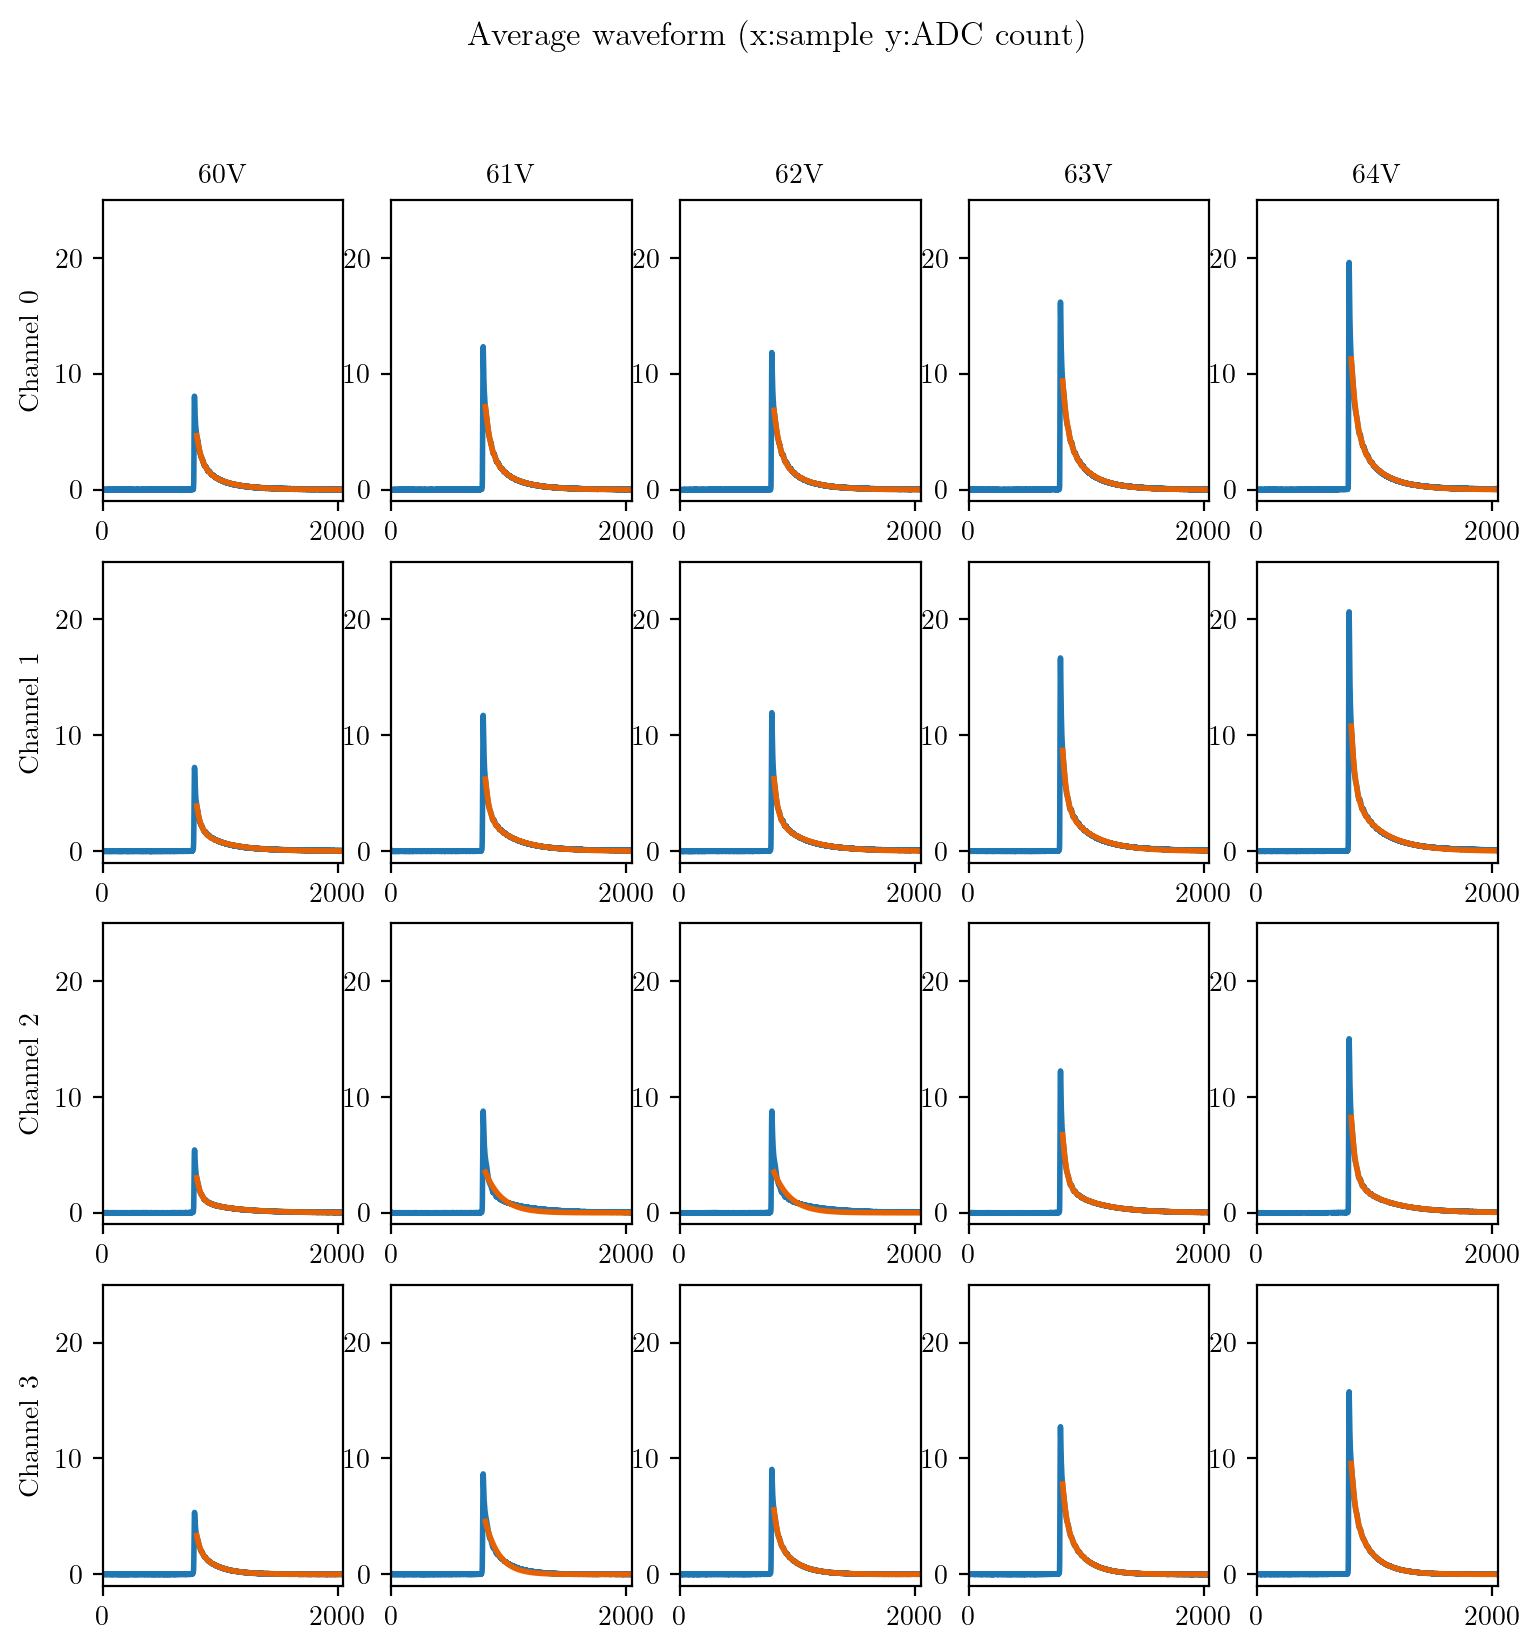

In [10]:
plt.figure(0,figsize=(9,9))#for charge histograms
plt.figure(1,figsize=(9,9))#for avg waveform histograms
bias = [60, 61, 62, 63, 64]
for ch in [0,1,2,3]:
    for volt_id,volt in enumerate(voltages): 
        print("ch{} {}".format(ch, volt))
        fname = "/home/aj9512/jadwin-365/data/sipm/{}/wave{}.dat".format(volt,ch)
        dt = np.dtype('<H')
        file = open(fname, 'rb')
        traces = np.fromfile(file, dtype=dt, count=-1)
        file.close()

        wfs = traces.reshape((-1,2048)).astype(float)
        wfs_sub_bsl = wfs
        integrals = []
        for i,wf in enumerate(wfs):
            wfs_sub_bsl[i] = - wf + np.mean(wf[:600]) #subtract baseline (avg. of first 600 samples)
            integrals.append(np.sum(wfs_sub_bsl[i][750:1200])) #integral between sample 750 and 1200
        #charge histogram
        h_intg, h_intg_bins = np.histogram(integrals, bins=np.linspace(-500, 5000, 500))#linspace(min, max, nbins)
        plt.figure(0)
        plt.subplot(4,5,ch*5+volt_id+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[volt_id]))
        if volt_id==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.step(h_intg_bins[:-1], h_intg, linewidth=1)
        plt.yscale('log')
        plt.xlim(-500, 5000)
        plt.ylim(1,1e4)

        # average waveform
        meanwf = np.zeros(2048)
        count = 0
        for wf_sub_bsl in wfs_sub_bsl:
            meanwf = meanwf*count + wf_sub_bsl
            count += 1
            meanwf = meanwf/count
        plt.figure(1)
        plt.subplot(4,5,ch*5+volt_id+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[volt_id]))
        if volt_id==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.plot(meanwf)
        popt,pcov = curve_fit(expo_pulse, np.linspace(800,2047,2048-800), meanwf[800:], p0=[10,100,10,10],maxfev=10000)
        plt.plot(np.linspace(800,2047,2048-800), expo_pulse(np.linspace(800,2047,2048-800),*popt))
        print(popt)
        plt.xlim(0,2048)
        plt.ylim(-1, 25)
plt.figure(0)
plt.suptitle('Charge distribution')
plt.figure(1)
plt.suptitle('Average waveform (x:sample y:ADC count)')

## Auto-regressive filter

In [7]:
h_ampfilt_ch_volt = np.zeros((4,5,1000))
h_ampfilt_bincent_ch_volt = np.zeros((4,5,1000))
h_ampfilt_binwid_ch_volt = np.zeros((4,5))
tau = 40 #AR filter parameter (should = time constant of pulse shape)
for ch in range(4):
    gain_fit = []
    for volt_id,volt in enumerate(voltages): 
        print("ch{} {}".format(ch, volt))
        fname = "/home/aj9512/jadwin-365/data/sipm/{}/wave{}.dat".format(volt,ch)
        dt = np.dtype('<H')
        file = open(fname, 'rb')
        traces = np.fromfile(file, dtype=dt, count=-1)
        file.close()

        traces = traces.reshape((-1,2048)).astype(float)
        #traces = traces[:10000] #use first 10000 waveforms
        traces = np.tile(np.mean(traces[:,:600],axis=1).reshape(100000,1),(1,2048)) - traces

        wfs_filt = AR_filter(traces, tau)
        amps_filt = np.max(wfs_filt,axis=1)
        
        #filtered amplitude histogram
        h_ampfilt, h_ampfilt_bins = np.histogram(amps_filt, bins=np.linspace(0, 1000, 1001))#linspace(min, max, nbins)
        h_ampfilt_bincent_ch_volt[ch][volt_id] = (h_ampfilt_bins[1:]+h_ampfilt_bins[:-1])/2
        h_ampfilt_ch_volt[ch][volt_id] = h_ampfilt
        h_ampfilt_binwid_ch_volt[ch][volt_id] = h_ampfilt_bins[1]-h_ampfilt_bins[0]

NameError: name 'voltages' is not defined

Channel 0 Vbd=54.651+/-0.106V
Channel 1 Vbd=54.671+/-0.145V
Channel 2 Vbd=54.722+/-0.042V
Channel 3 Vbd=54.881+/-0.016V


Text(0.5, 0.98, 'Breakdown Voltage')

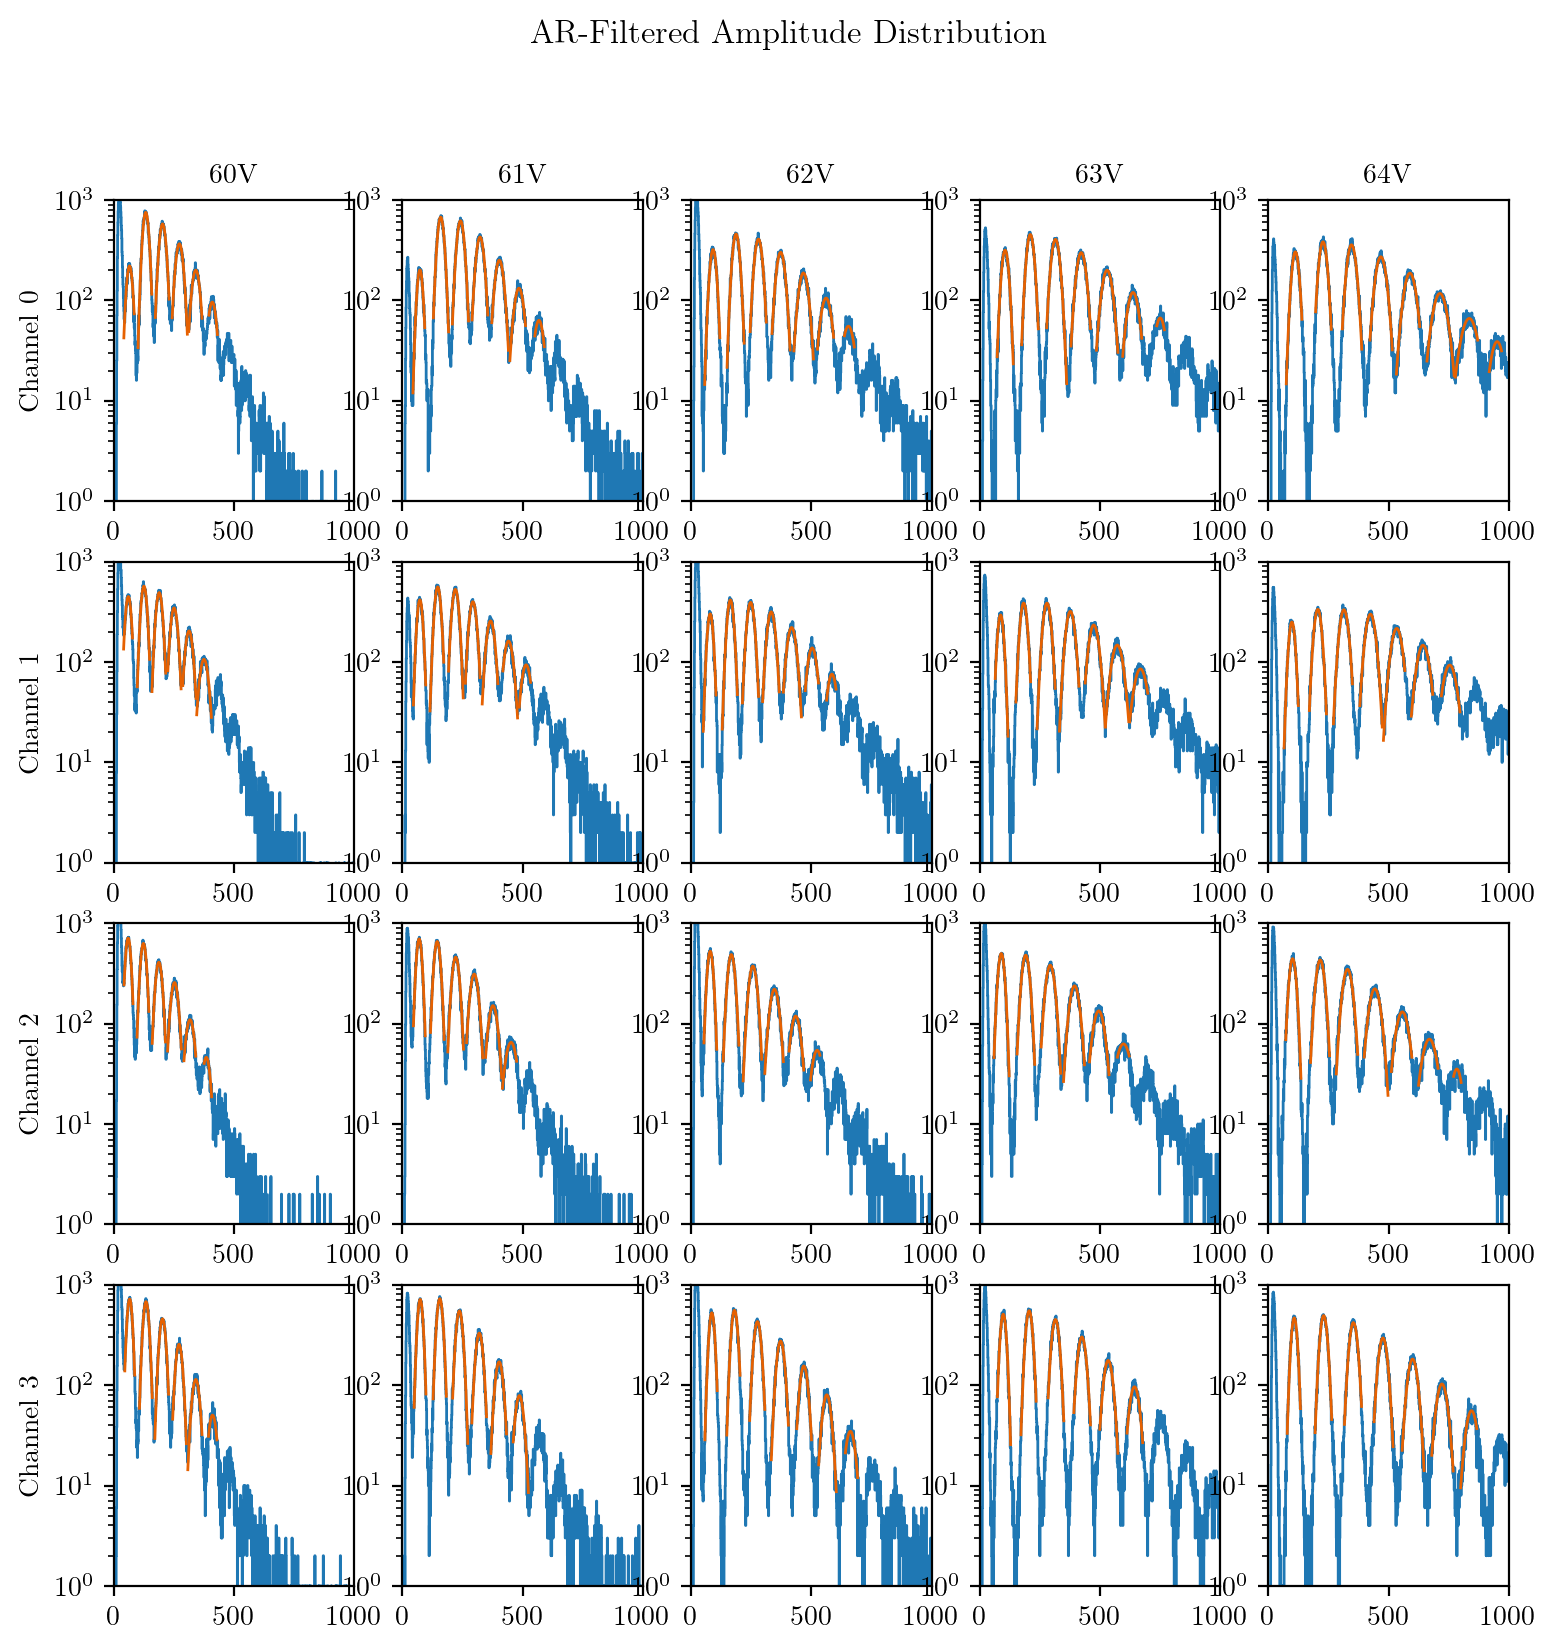

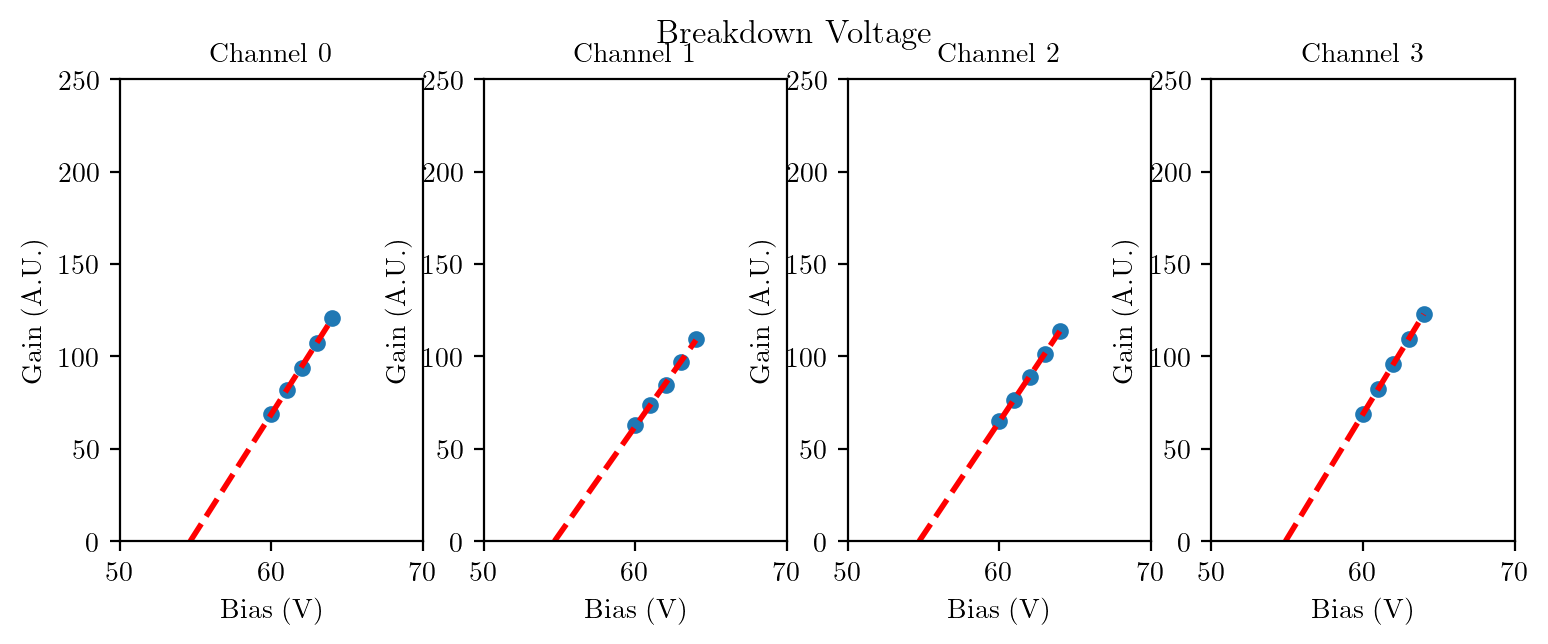

In [29]:
plt.figure(0,figsize=(9,9))#for charge histograms
plt.figure(1,figsize=(9,3))#for breakdown voltage fit
bias = [60, 61, 62, 63, 64]
for ch in range(4):
    gain_fit = []
    for volt_id,volt in enumerate(voltages): 
        #filtered amplitude histogram
        plt.figure(0)
        plt.subplot(4,5,ch*5+volt_id+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[volt_id]))
        if volt_id==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.step(h_ampfilt_bincent_ch_volt[ch][volt_id], h_ampfilt_ch_volt[ch][volt_id], linewidth=1)
        plt.yscale('log')
        plt.xlim(0, 1000)
        plt.ylim(1, 1e3)
        # find pe peaks in histogram
        peaks,pdict = find_peaks(h_ampfilt_ch_volt[ch][volt_id][30:], prominence=20, width=15, distance=20)
#         print("peaks:", peaks)
#         print("pdict:", pdict)
        #fit pe peaks with Gaussian
        pe_mean = []
        for ip,peak_bin in enumerate(peaks):
            peak_bin = peak_bin + 30
            pe_width_bin = int(pdict['widths'][ip])
            pe_width_x = h_ampfilt_binwid_ch_volt[ch][volt_id]*pe_width_bin
            min_bin = peak_bin-pe_width_bin
            max_bin = peak_bin+pe_width_bin
            min_x = h_ampfilt_bincent_ch_volt[ch][volt_id][0] + h_ampfilt_binwid_ch_volt[ch][volt_id]*min_bin
            max_x = h_ampfilt_bincent_ch_volt[ch][volt_id][0] + h_ampfilt_binwid_ch_volt[ch][volt_id]*max_bin
            peak_x = h_ampfilt_bincent_ch_volt[ch][volt_id][0] + h_ampfilt_binwid_ch_volt[ch][volt_id]*peak_bin
            popt,pcov = curve_fit(gauss, h_ampfilt_bincent_ch_volt[ch][volt_id][min_bin:max_bin], h_ampfilt_ch_volt[ch][volt_id][min_bin:max_bin], p0=[h_ampfilt_ch_volt[ch][volt_id][peak_bin], peak_x, pe_width_x], maxfev=10000)
            plt.plot(h_ampfilt_bincent_ch_volt[ch][volt_id][min_bin:max_bin], gauss(h_ampfilt_bincent_ch_volt[ch][volt_id][min_bin:max_bin], *popt), color=colors[1], lw=1, zorder=10)
#             print("[N,mu,sigma]={}".format(popt))
            pe_mean.append(popt[1])
        
        #fit pe-mean vs pe with linear
        xlin = np.linspace(1,len(peaks),len(peaks))
        ylin = pe_mean
        popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], maxfev=10000)
#         print("gain={}(au)".format(popt[0]))
        gain_fit.append(popt[0])
    #breakdown voltage fit and plot
    xlin = bias
    ylin = gain_fit
    popt,pcov = curve_fit(line_vbd, xlin, ylin, p0=[20, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V".format(ch,popt[1],np.sqrt(pcov[1,1])))
    plt.figure(1)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel('Gain (A.U.)')
    plt.xlabel('Bias (V)')
    plt.plot(xlin,ylin,'o', markersize=5)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,70)
    plt.ylim(0,250)
        
plt.figure(0)
plt.suptitle('AR-Filtered Amplitude Distribution')
plt.figure(1)
plt.suptitle('Breakdown Voltage')

# Bottom tile directories (0926 data)

In [6]:
voltages = ['20220926_bottom_65V_laser_thres3715',
            '20220926_bottom_67V_laser_thres3712',
            '20220926_bottom_69V_laser_thres3710',
            '20220926_bottom_71V_laser_thres3706',
            '20220926_bottom_73V_laser_thres3703']

ch0 20220926_bottom_65V_laser_thres3715
trigger position: sample 782
a1=13.5665 tau1=331.3431 a2=114.8143 tau2=30.7736
ch0 20220926_bottom_67V_laser_thres3712
trigger position: sample 782
a1=33.9286 tau1=306.1795 a2=286.4979 tau2=29.0154
ch0 20220926_bottom_69V_laser_thres3710
trigger position: sample 782
a1=40.9731 tau1=303.6324 a2=343.8756 tau2=29.2659
ch0 20220926_bottom_71V_laser_thres3706
trigger position: sample 782
a1=57.1488 tau1=301.3161 a2=461.2446 tau2=30.2696
ch0 20220926_bottom_73V_laser_thres3703
trigger position: sample 782
a1=69.1229 tau1=294.5330 a2=532.6342 tau2=30.9984
ch1 20220926_bottom_65V_laser_thres3715
trigger position: sample 782
a1=8.8454 tau1=406.6827 a2=112.6670 tau2=35.2579
ch1 20220926_bottom_67V_laser_thres3712
trigger position: sample 783
a1=20.9732 tau1=382.9150 a2=263.7749 tau2=34.8645
ch1 20220926_bottom_69V_laser_thres3710
trigger position: sample 783
a1=24.8917 tau1=385.1538 a2=313.3224 tau2=35.3573
ch1 20220926_bottom_71V_laser_thres3706
trigger p

Text(0.5, 0.98, 'Average waveform (x:sample y:ADC count)')

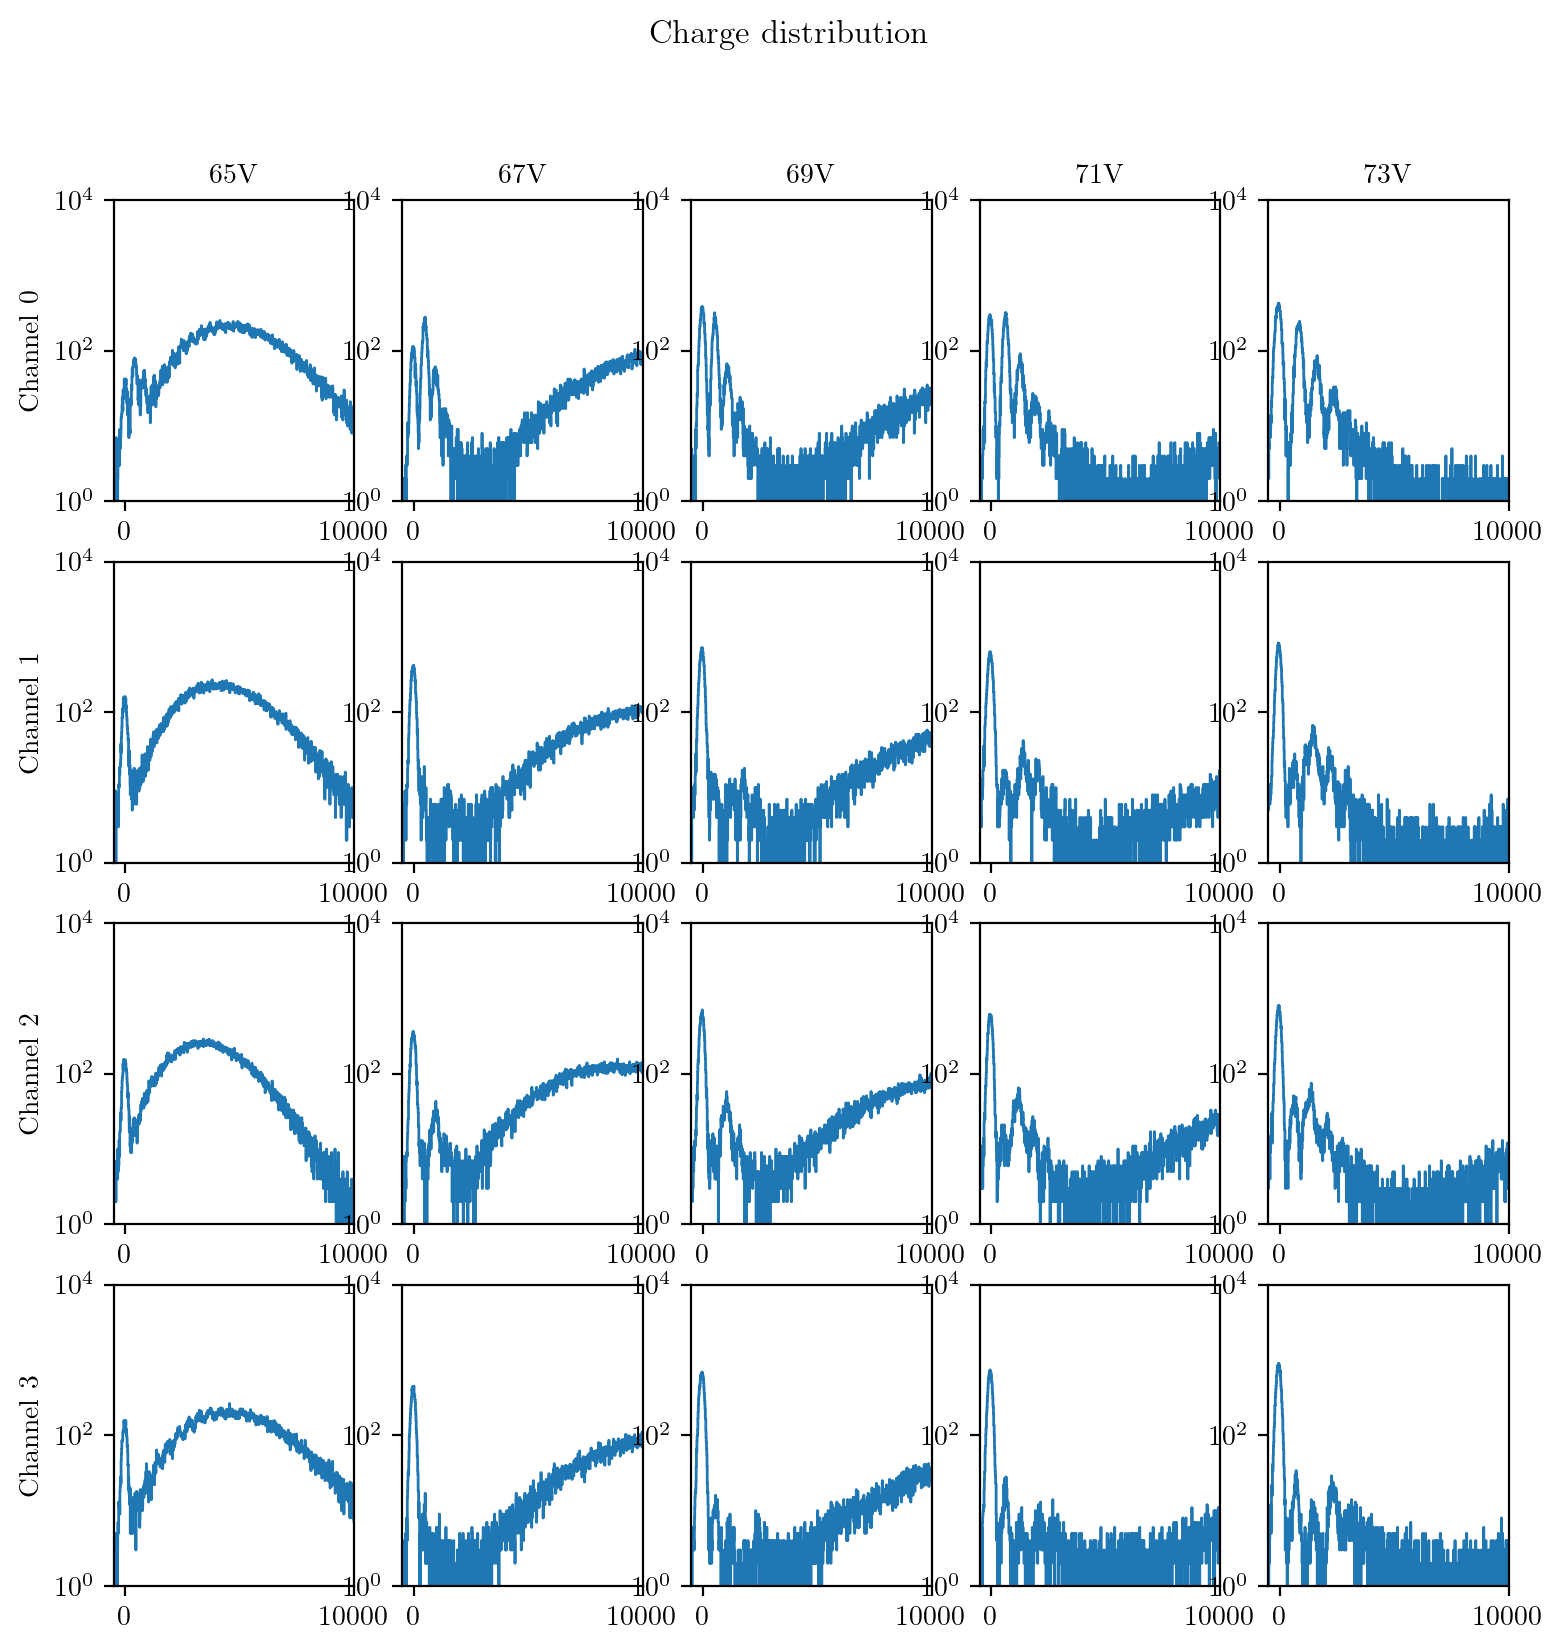

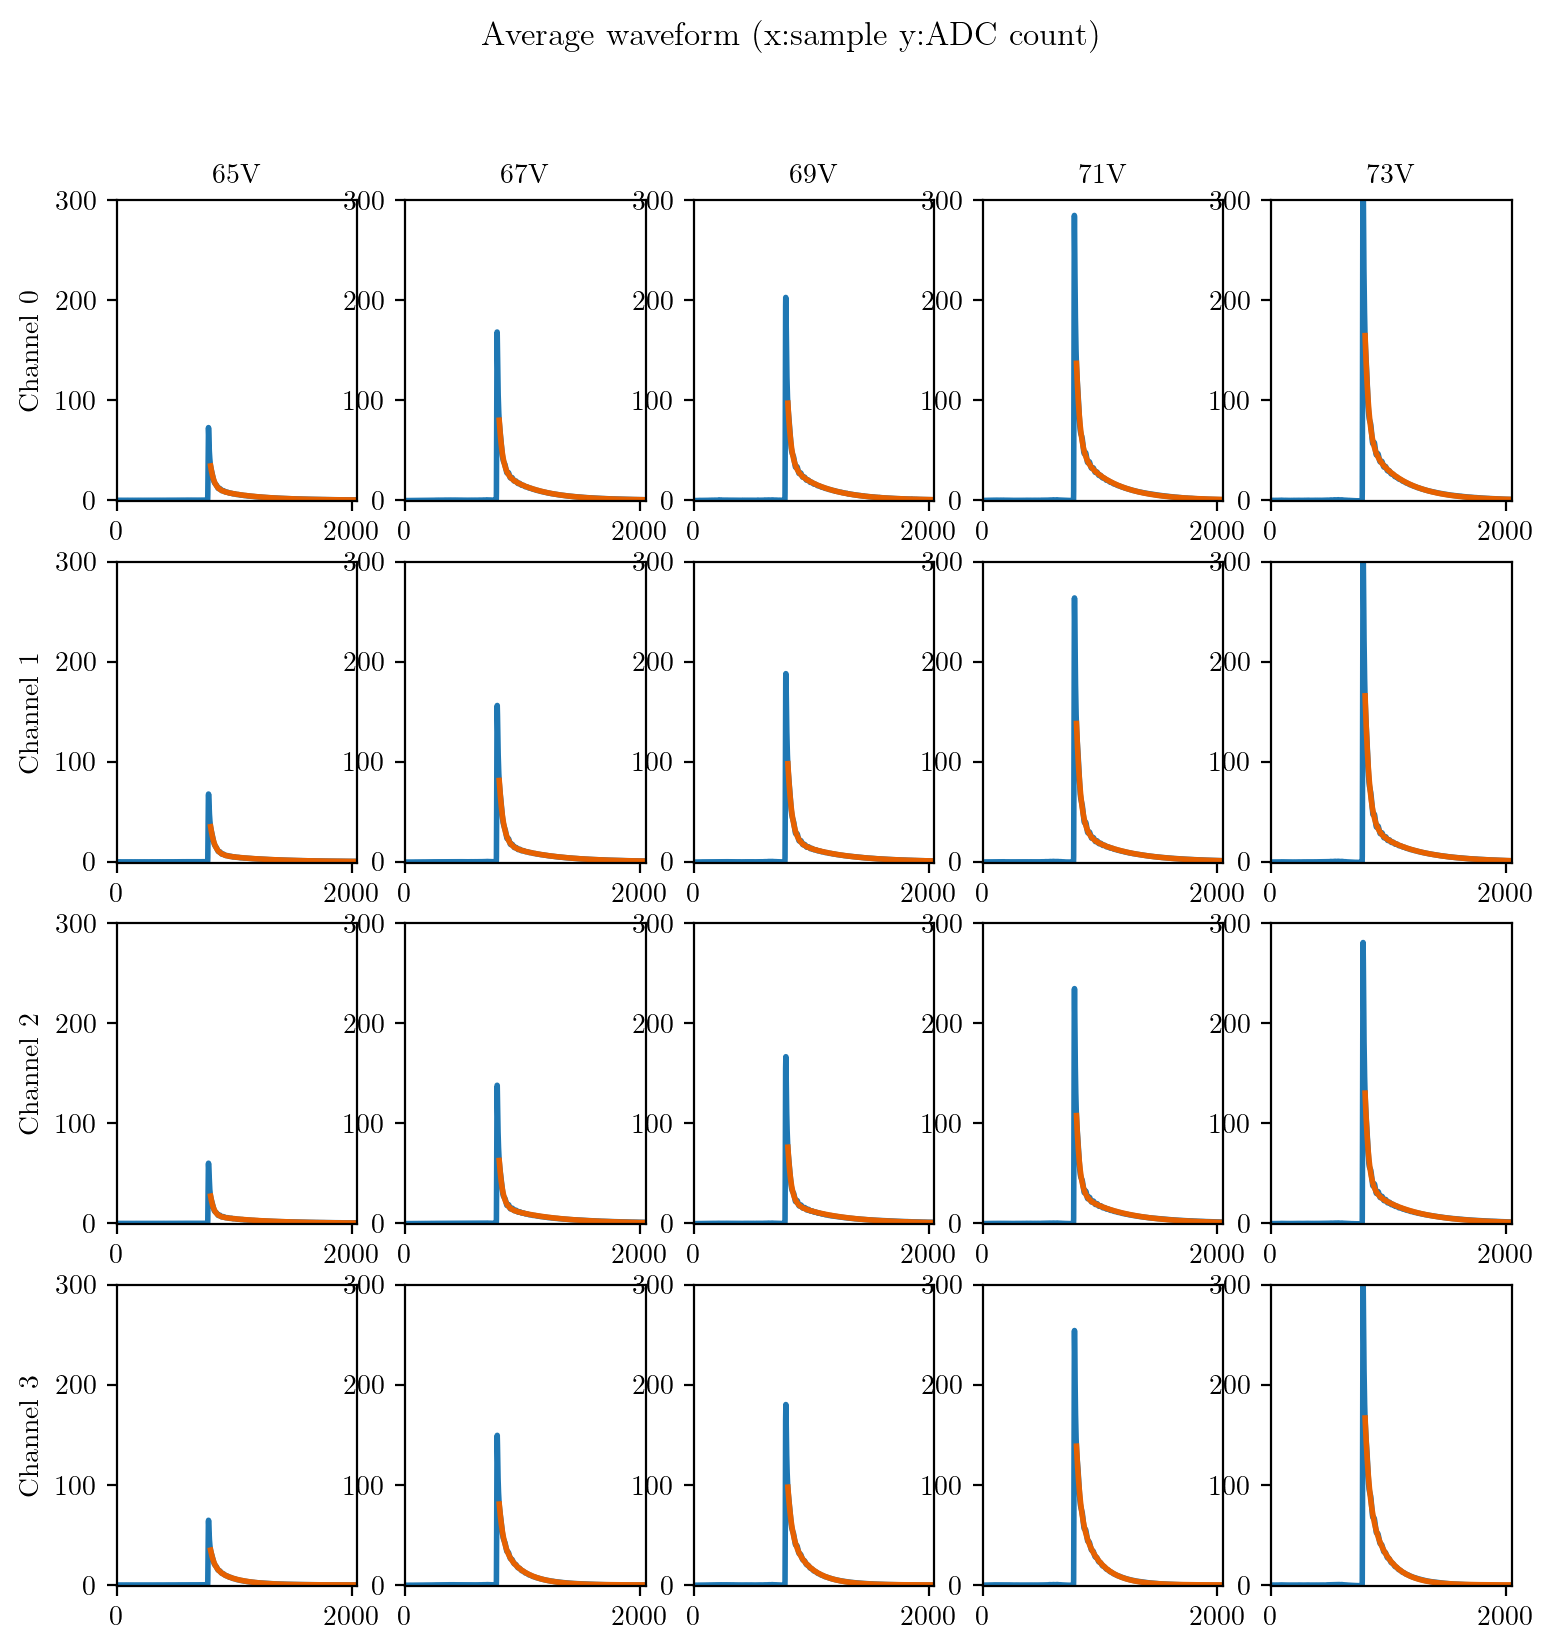

In [11]:
plt.figure(0,figsize=(9,9))#for charge histograms
plt.figure(1,figsize=(9,9))#for avg waveform histograms
bias = [65, 67, 69, 71, 73]
for ch in [0,1,2,3]:
    for volt_id,volt in enumerate(voltages): 
        print("ch{} {}".format(ch, volt))
        fname = "/home/aj9512/jadwin-365/data/sipm/{}/wave{}.dat".format(volt,ch)
        dt = np.dtype('<H')
        file = open(fname, 'rb')
        traces = np.fromfile(file, dtype=dt, count=-1)
        file.close()

        wfs = traces.reshape((-1,2048)).astype(float)
        wfs_sub_bsl = wfs
        integrals = []
        for i,wf in enumerate(wfs):
            wfs_sub_bsl[i] = - wf + np.mean(wf[:600]) #subtract baseline (avg. of first 600 samples)
            integrals.append(np.sum(wfs_sub_bsl[i][750:1300])) #integral between sample 750 and 1200
        #charge histogram
        h_intg, h_intg_bins = np.histogram(integrals, bins=np.linspace(-500, 10000, 1000))#linspace(min, max, nbins)
        plt.figure(0)
        plt.subplot(4,5,ch*5+volt_id+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[volt_id]))
        if volt_id==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.step(h_intg_bins[:-1], h_intg, linewidth=1)
        plt.yscale('log')
        plt.xlim(-500, 10000)
        plt.ylim(1,1e4)

        # average waveform
        meanwf = np.zeros(2048)
        count = 0
        for wf_sub_bsl in wfs_sub_bsl:
            meanwf = meanwf*count + wf_sub_bsl
            count += 1
            meanwf = meanwf/count
        print("trigger position: sample {}".format(np.argmax(meanwf)))
        plt.figure(1)
        plt.subplot(4,5,ch*5+volt_id+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[volt_id]))
        if volt_id==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.plot(meanwf)
        popt,pcov = curve_fit(expo_pulse, np.linspace(800,2047,2048-800), meanwf[800:], p0=[10,100,10,10],maxfev=10000)
        plt.plot(np.linspace(800,2047,2048-800), expo_pulse(np.linspace(800,2047,2048-800),*popt))
        print("a1={:.4f} tau1={:.4f} a2={:.4f} tau2={:.4f}".format(*popt))
        plt.xlim(0,2048)
        plt.ylim(-1, 300)
plt.figure(0)
plt.suptitle('Charge distribution')
plt.figure(1)
plt.suptitle('Average waveform (x:sample y:ADC count)')

In [9]:
nbins = 500
h_ampfilt_ch_volt = np.zeros((4,5,nbins))
h_ampfilt_bincent_ch_volt = np.zeros((4,5,nbins))
h_ampfilt_binwid_ch_volt = np.zeros((4,5))
tau = 30 #AR filter parameter (should = time constant of pulse shape)
timewindow=[775,790]
for ch in range(4):
    gain_fit = []
    for volt_id,volt in enumerate(voltages): 
        print("ch{} {}".format(ch, volt))
        fname = "/home/aj9512/jadwin-365/data/sipm/{}/wave{}.dat".format(volt,ch)
        dt = np.dtype('<H')
        file = open(fname, 'rb')
        traces = np.fromfile(file, dtype=dt, count=-1)
        file.close()

        traces = traces.reshape((-1,2048)).astype(float)
        #traces = traces[:10000] #use first 10000 waveforms
        traces = np.tile(np.mean(traces[:,:600],axis=1).reshape(100000,1),(1,2048)) - traces

        wfs_filt = AR_filter(traces, tau)
        amps_filt = np.max(wfs_filt[:,timewindow[0]:timewindow[1]],axis=1)
        
        #filtered amplitude histogram
        h_ampfilt, h_ampfilt_bins = np.histogram(amps_filt, bins=np.linspace(0, 2000, nbins+1))#linspace(min, max, nbins)
        h_ampfilt_bincent_ch_volt[ch][volt_id] = (h_ampfilt_bins[1:]+h_ampfilt_bins[:-1])/2
        h_ampfilt_ch_volt[ch][volt_id] = h_ampfilt
        h_ampfilt_binwid_ch_volt[ch][volt_id] = h_ampfilt_bins[1]-h_ampfilt_bins[0]

ch0 20220926_bottom_65V_laser_thres3715
ch0 20220926_bottom_67V_laser_thres3712
ch0 20220926_bottom_69V_laser_thres3710
ch0 20220926_bottom_71V_laser_thres3706
ch0 20220926_bottom_73V_laser_thres3703
ch1 20220926_bottom_65V_laser_thres3715
ch1 20220926_bottom_67V_laser_thres3712
ch1 20220926_bottom_69V_laser_thres3710
ch1 20220926_bottom_71V_laser_thres3706
ch1 20220926_bottom_73V_laser_thres3703
ch2 20220926_bottom_65V_laser_thres3715
ch2 20220926_bottom_67V_laser_thres3712
ch2 20220926_bottom_69V_laser_thres3710
ch2 20220926_bottom_71V_laser_thres3706
ch2 20220926_bottom_73V_laser_thres3703
ch3 20220926_bottom_65V_laser_thres3715
ch3 20220926_bottom_67V_laser_thres3712
ch3 20220926_bottom_69V_laser_thres3710
ch3 20220926_bottom_71V_laser_thres3706
ch3 20220926_bottom_73V_laser_thres3703


Channel 0 Vbd=37.673+/-45.668V
Channel 1 Vbd=70.477+/-1.578V
Channel 2 Vbd=45.952+/-57.570V
Channel 3 Vbd=63.263+/-6.957V


/home/as111/.conda/envs/ds-pu/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Text(0.5, 0.98, 'Breakdown Voltage')

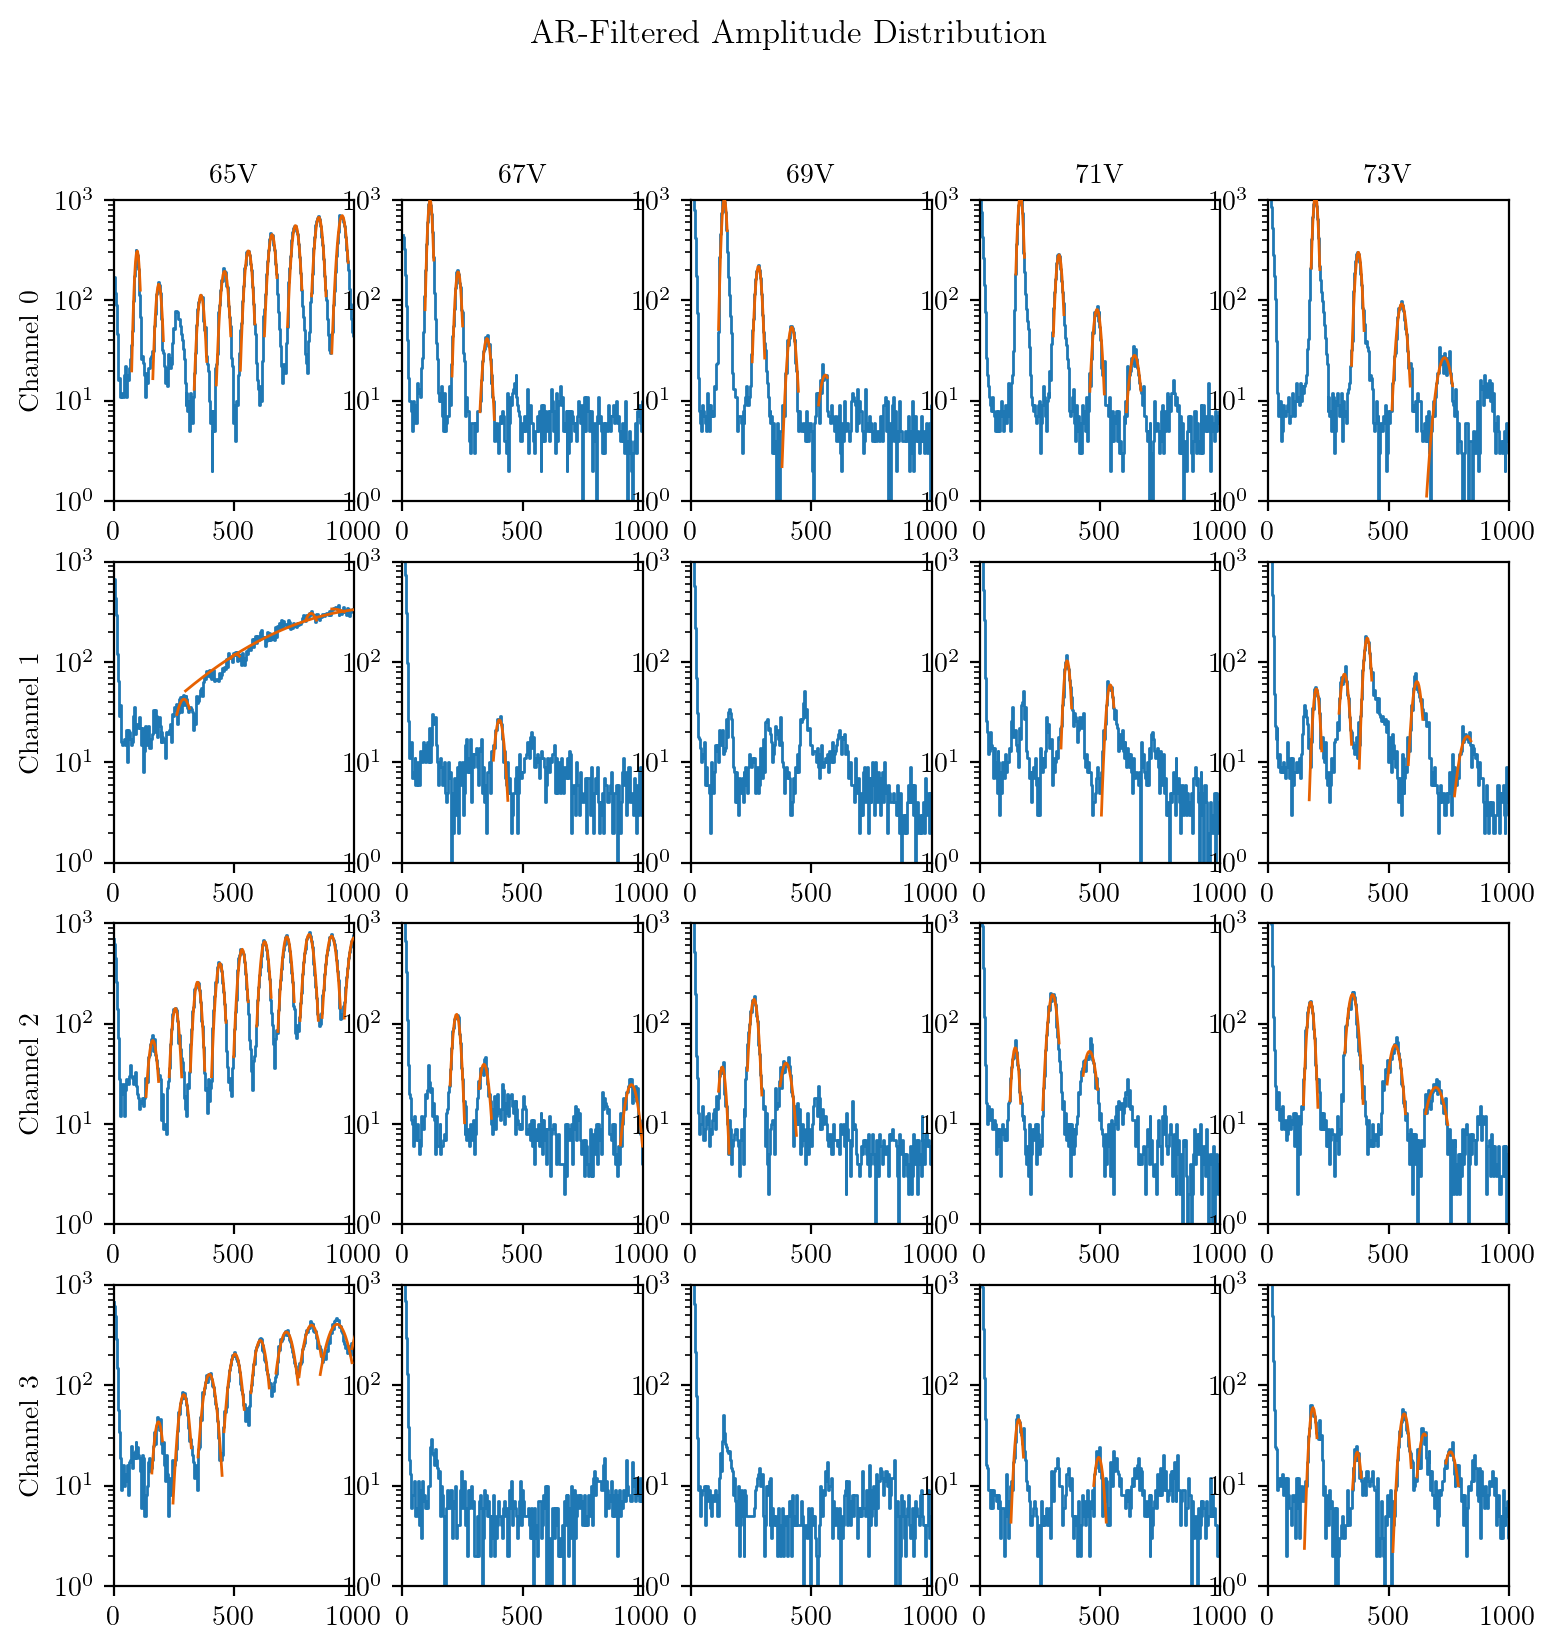

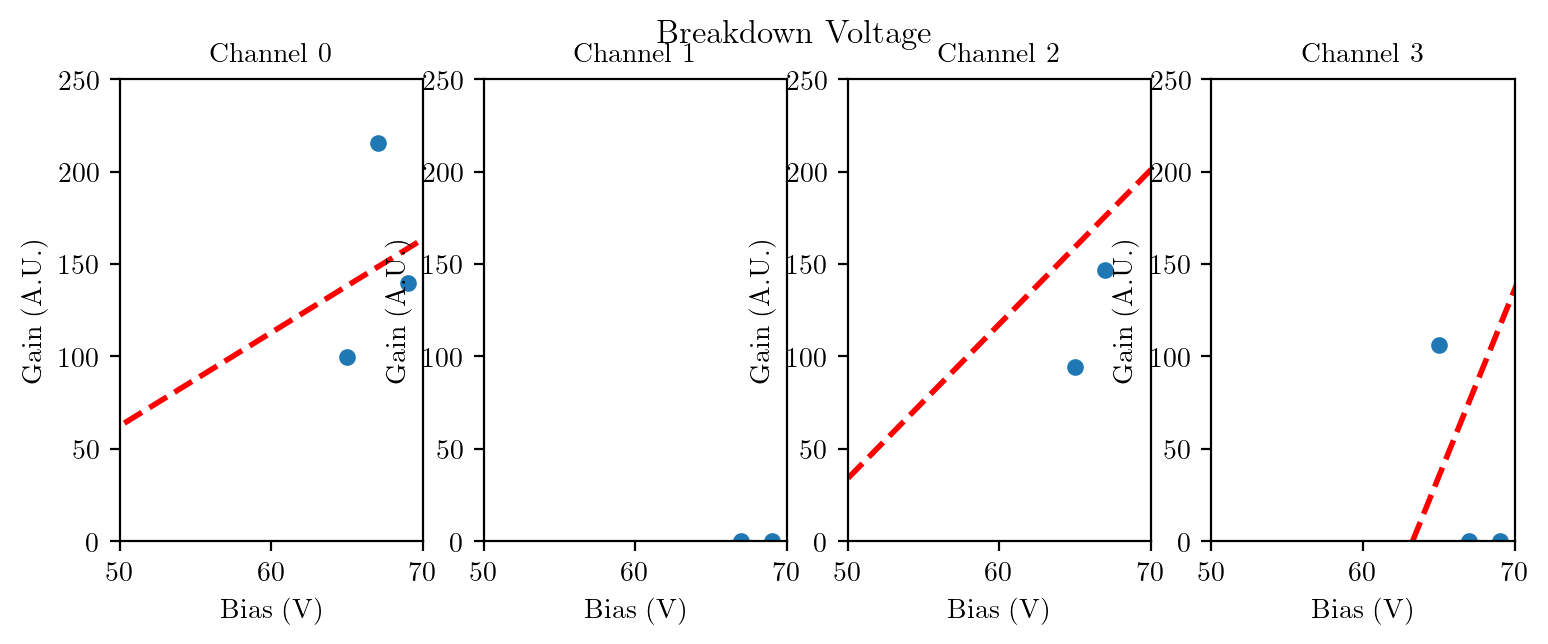

In [10]:
plt.figure(0,figsize=(9,9))#for charge histograms
plt.figure(1,figsize=(9,3))#for breakdown voltage fit
bias = [65, 67, 69, 71, 73]
for ch in range(4):
    gain_fit = []
    for volt_id,volt in enumerate(voltages): 
        #filtered amplitude histogram
        plt.figure(0)
        plt.subplot(4,5,ch*5+volt_id+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[volt_id]))
        if volt_id==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.step(h_ampfilt_bincent_ch_volt[ch][volt_id], h_ampfilt_ch_volt[ch][volt_id], linewidth=1)
        plt.yscale('log')
        plt.xlim(0, 1000)
        plt.ylim(1, 1e3)
        # find pe peaks in histogram
        threshold = 15 #
        peaks,pdict = find_peaks(h_ampfilt_ch_volt[ch][volt_id][threshold:], prominence=20, width=5, distance=20)
#         print("peaks:", peaks)
#         print("pdict:", pdict)
        #fit pe peaks with Gaussian
        pe_mean = []
        
        for ip,peak_bin in enumerate(peaks):
            peak_bin = peak_bin + threshold
            pe_width_bin = int(pdict['widths'][ip])
            pe_width_x = h_ampfilt_binwid_ch_volt[ch][volt_id]*pe_width_bin
            min_bin = peak_bin-pe_width_bin
            max_bin = peak_bin+pe_width_bin
            min_x = h_ampfilt_bincent_ch_volt[ch][volt_id][0] + h_ampfilt_binwid_ch_volt[ch][volt_id]*min_bin
            max_x = h_ampfilt_bincent_ch_volt[ch][volt_id][0] + h_ampfilt_binwid_ch_volt[ch][volt_id]*max_bin
            peak_x = h_ampfilt_bincent_ch_volt[ch][volt_id][0] + h_ampfilt_binwid_ch_volt[ch][volt_id]*peak_bin
            popt,pcov = curve_fit(gauss, h_ampfilt_bincent_ch_volt[ch][volt_id][min_bin:max_bin], h_ampfilt_ch_volt[ch][volt_id][min_bin:max_bin], p0=[h_ampfilt_ch_volt[ch][volt_id][peak_bin], peak_x, pe_width_x], maxfev=10000)
            plt.plot(h_ampfilt_bincent_ch_volt[ch][volt_id][min_bin:max_bin], gauss(h_ampfilt_bincent_ch_volt[ch][volt_id][min_bin:max_bin], *popt), color=colors[1], lw=1, zorder=10)
#             print("[N,mu,sigma]={}".format(popt))
            pe_mean.append(popt[1])
        
        #fit pe-mean vs pe with linear
        if len(peaks)>1:
            xlin = np.linspace(1,len(peaks),len(peaks))
            ylin = pe_mean
            popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], maxfev=10000)
    #         print("gain={}(au)".format(popt[0]))
            gain_fit.append(popt[0])
        else:
            gain_fit.append(0)
    #breakdown voltage fit and plot
    xlin = bias
    ylin = gain_fit
    popt,pcov = curve_fit(line_vbd, xlin, ylin, p0=[20, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V".format(ch,popt[1],np.sqrt(pcov[1,1])))
    plt.figure(1)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel('Gain (A.U.)')
    plt.xlabel('Bias (V)')
    plt.plot(xlin,ylin,'o', markersize=5)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,70)
    plt.ylim(0,250)
        
plt.figure(0)
plt.suptitle('AR-Filtered Amplitude Distribution')
plt.figure(1)
plt.suptitle('Breakdown Voltage')